# Анализ поступающих в ЕГАИС документов

# Цель анализа - определить зависимость между количеством и объемом поступаемых в ЕГАИС документов со временем их обработки. 

### Технический код

In [79]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pyodbc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

### Подключение к базе данных, содержащей документы. Демонстрация первых 5 записей таблицы.

In [80]:
connect = pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
                        "Server=10.10.5.160;"
                        "Database=unionmaindoctwb;"
                        "uid=debian; pwd=Qwerty1234")
r = pd.read_sql_query('select top 10 * from [dbo].[Stat]',  connect)
r.head()

rcn       OwnerId  CurrSize                 Created        DocType  \
0  500813824  010060695582     11955 2019-01-01 00:00:00.067  AsiiuTimesign   
1  500813825  030000008107     10593 2019-01-01 00:00:00.203  AsiiuTimesign   
2  500813826  010060694028     13252 2019-01-01 00:00:00.260  AsiiuTimesign   
3  500813827  030000000003     11387 2019-01-01 00:00:00.293  AsiiuTimesign   
4  500813828  030000011765     10979 2019-01-01 00:00:00.283  AsiiuTimesign   

                                  DocId           FO_InsertDate  \
0  0221D82D-3DD2-48B1-BEAD-0EB696488549 2019-01-01 00:00:01.330   
1  49510ED9-26FA-4ECD-969F-95C8B07B8D55 2019-01-01 00:00:01.640   
2  E8BCA59A-37CD-4422-B878-89F4D8F056CE 2019-01-01 00:00:01.667   
3  6138DE43-C0CD-49DA-9491-25D17591DAD7 2019-01-01 00:00:01.583   
4  A73AE489-690F-4600-A9FF-B60D52FA1CEA 2019-01-01 00:00:01.613   

   ProcessingTime      FO_id  
0            1263  764750282  
1            1436  764750313  
2            1406  764750316  
3            1290  764750307  
4            1330  764750310

### SQL-запрос возвращает количество чеков, суммарный объем документов в килобайтах и суммарную продолжительность обработки документов сгруппированные по типу документа и по времени создания. Временной интервал - 1 минута

In [81]:
docs = pd.read_sql_query('select cast (Created as SmallDateTime) as datetime, DocType, count(rcn) as qnt, sum(CurrSize)/1024 as CurrSize_kb, sum(ProcessingTime)/1000 as ProcessingTime_sec \
from [dbo].[Stat] \
group by cast (Created as SmallDateTime), DocType',  connect)
docs.head()

datetime             DocType  qnt  CurrSize_kb  \
0 2019-05-20 20:44:00       ActFixBarCode    1           29   
1 2019-06-16 18:28:00      TransferToShop  214         1436   
2 2019-02-05 18:46:00  ActWriteOffShop_v2  247         3951   
3 2019-07-19 03:22:00       WayBillAct_v3   95          311   
4 2019-01-13 03:18:00  ActChargeOnShop_v2    9         1266   

   ProcessingTime_sec  
0                   8  
1                 418  
2                 224  
3                 149  
4                  26

In [82]:
print('Количество типов документов {}'.format(docs.DocType.nunique()))
print('Количество документов всего {} млн'.format(docs.qnt.sum().round(-5)/1000000))
print('Период анализа с {} по {}'.format(docs.datetime.min().date(), docs.datetime.max().date()))

Количество типов документов 112
Количество документов всего 411.2 млн
Период анализа с 2019-01-01 по 2019-07-20


#  Топ 5 документов по количеству

In [83]:
docs.DocType = docs.DocType.apply(lambda x: x.upper())

In [84]:
tabl = docs.groupby('DocType')['qnt', 'CurrSize_kb'].agg({'qnt':'sum', 'CurrSize_kb': lambda x: x.sum()}).sort_values(by='qnt', ascending=False)
tabl['Доля_%_колво'] = tabl.qnt/ tabl.qnt.sum()
tabl['Доля_%_объем'] = tabl.CurrSize_kb/ tabl.CurrSize_kb.sum()
tabl['Доля_накопительный_итог_количество'] = tabl['Доля_%_колво'].cumsum()
tabl['Доля_накопительный_итог_объем'] = tabl['Доля_%_объем'].cumsum()
tabl.head(6)

qnt  CurrSize_kb  Доля_%_колво  Доля_%_объем  \
DocType                                                                 
TRANSFERTOSHOP      98680872    545818565      0.239997      0.059859   
ASIIUTIMESIGN       92652633    995339006      0.225336      0.109157   
ACTWRITEOFFSHOP_V2  82048384   2036578720      0.199546      0.223347   
WAYBILL_V3          54863464   4715505803      0.133431      0.517139   
WAYBILLACT_V3       50390826    194029888      0.122553      0.021279   
ACTWRITEOFF_V3      19225155    210988055      0.046757      0.023139   

                    Доля_накопительный_итог_количество  \
DocType                                                  
TRANSFERTOSHOP                                0.239997   
ASIIUTIMESIGN                                 0.465334   
ACTWRITEOFFSHOP_V2                            0.664880   
WAYBILL_V3                                    0.798311   
WAYBILLACT_V3                                 0.920864   
ACTWRITEOFF_V3                                0.967621   

                    Доля_накопительный_итог_объем  
DocType                                            
TRANSFERTOSHOP                           0.059859  
ASIIUTIMESIGN                            0.169015  
ACTWRITEOFFSHOP_V2                       0.392362  
WAYBILL_V3                               0.909501  
WAYBILLACT_V3                            0.930780  
ACTWRITEOFF_V3                           0.953918

## Видим, что 95% массы по количеству и объему документов составляют 6 документов из 41

In [85]:
translator = pd.read_excel(r'/run/user/1000/gvfs/smb-share:server=10.32.0.81,share=users/Magomedov-az/Documents/sync\translator.xlsx' )

In [86]:
docs = docs.merge(translator, on='DocType', how='left')
docs.rename(columns={'DocTypeRu': 'Документ','qnt': 'Количество' ,'CurrSize_kb': 'Размер_КБ', 'ProcessingTime_sec' :'Время_обработки_сек' }, inplace=True)

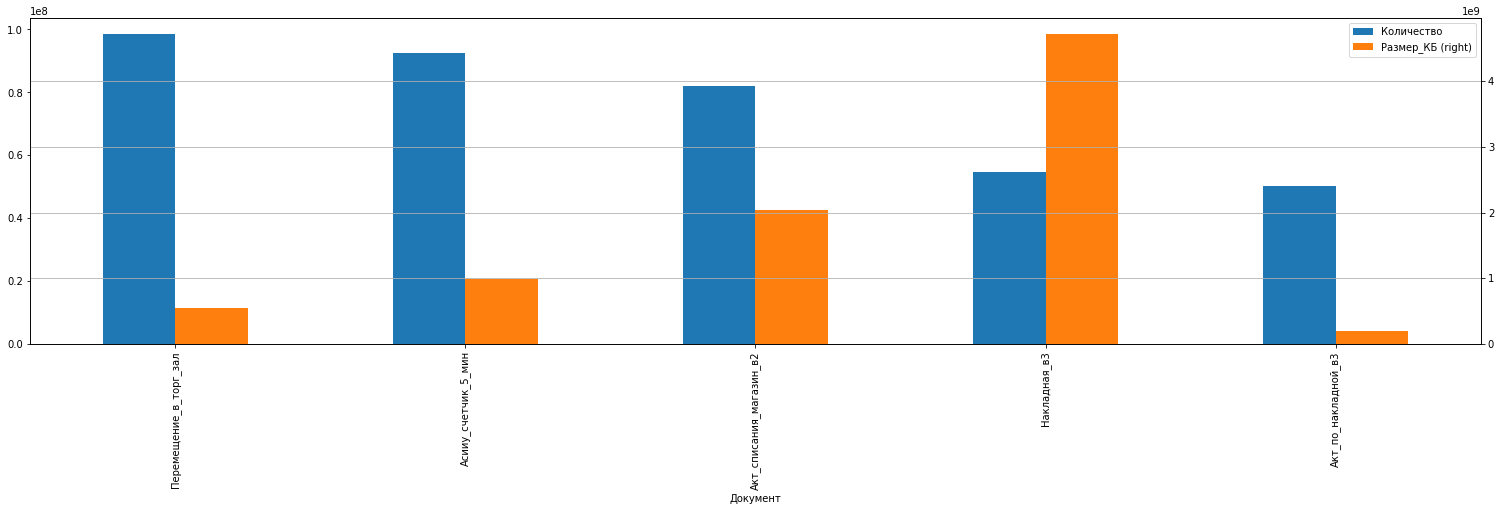

In [87]:
docs.groupby('Документ')['Количество', 'Размер_КБ'].agg({'Количество':'sum', 'Размер_КБ': lambda x: x.sum()}).sort_values(by='Количество', ascending=False).head(5).plot(kind='bar', figsize=(26,6), secondary_y= 'Размер_КБ')
plt.grid(True);

In [88]:
top_5 = docs.groupby(['DocType', 'Документ'])['Количество','Размер_КБ','Время_обработки_сек'].sum().sort_values(by='Количество', ascending=False).reset_index().head(5)
top_5

DocType                 Документ  Количество   Размер_КБ  \
0      TRANSFERTOSHOP   Перемещение_в_торг_зал    98680872   545818565   
1       ASIIUTIMESIGN      Асииу_счетчик_5_мин    92652633   995339006   
2  ACTWRITEOFFSHOP_V2  Акт_списания_магазин_в2    82048384  2036578720   
3          WAYBILL_V3             Накладная_в3    54863464  4715505803   
4       WAYBILLACT_V3      Акт_по_накладной_в3    50390826   194029888   

   Время_обработки_сек  
0           2151946452  
1            354158797  
2           1207436814  
3            932821023  
4          35276006005

##  Топ 5 документов - сравнение по долям. Слева размер, справа количество

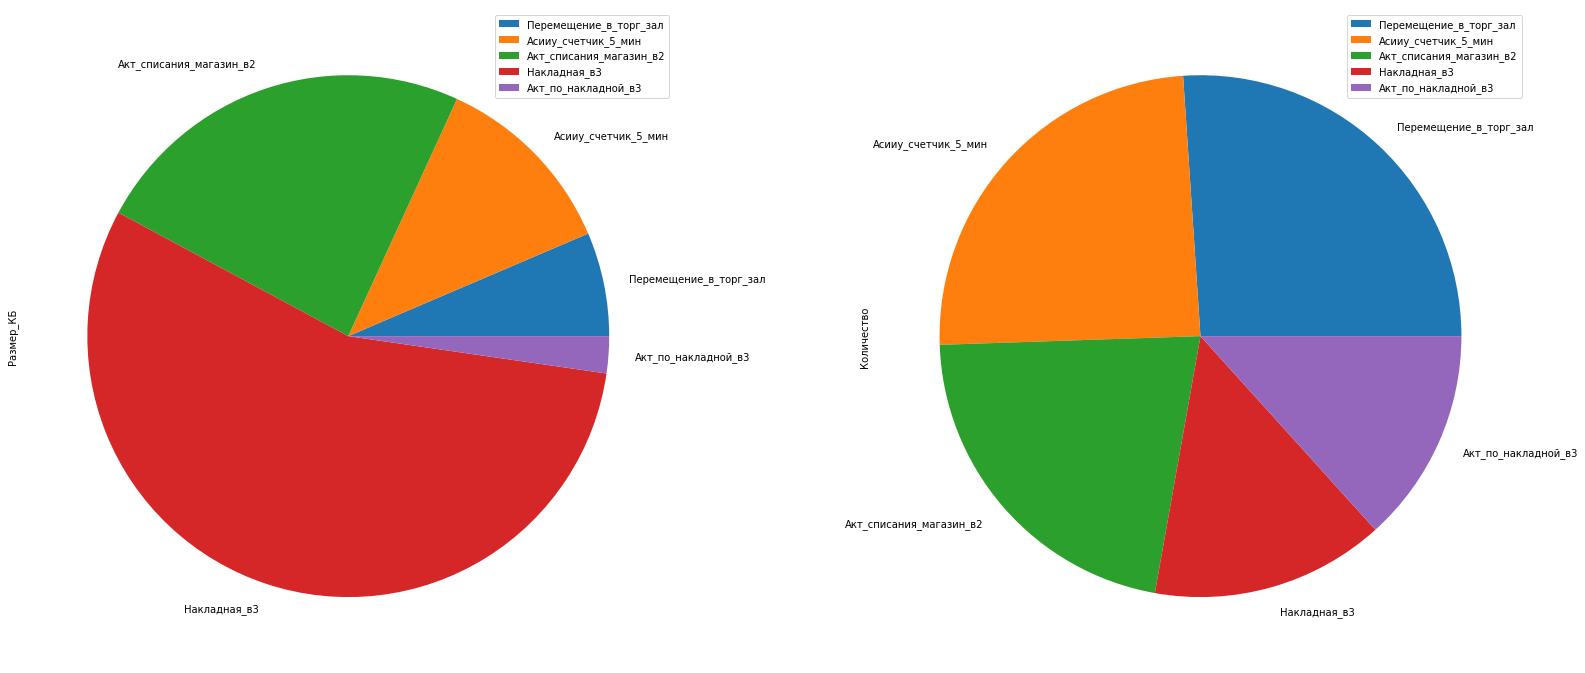

In [89]:
top_5.head(5).set_index('Документ').plot(kind='pie', y=['Размер_КБ', 'Количество'], subplots=True, figsize=(28,12));

# Анализ документов по отдельности. В настоящем анализе в качестве целевой (искомой) переменной будет выступать общее время обработки документов на сервере с момента попадания их в УТМ до момента завершения проверки валидности. Зависимость будет определеяться на основании объема и количества документов.

### Перемещение в торговый зал (TransferToShop)

## Гистограмма принимает на вход один числовой ряд и показывает количественное соотношение величин или распределение частоты значений в ряде. По оси Х указана величина значения, по У - частота, с которой это значение встречается. 

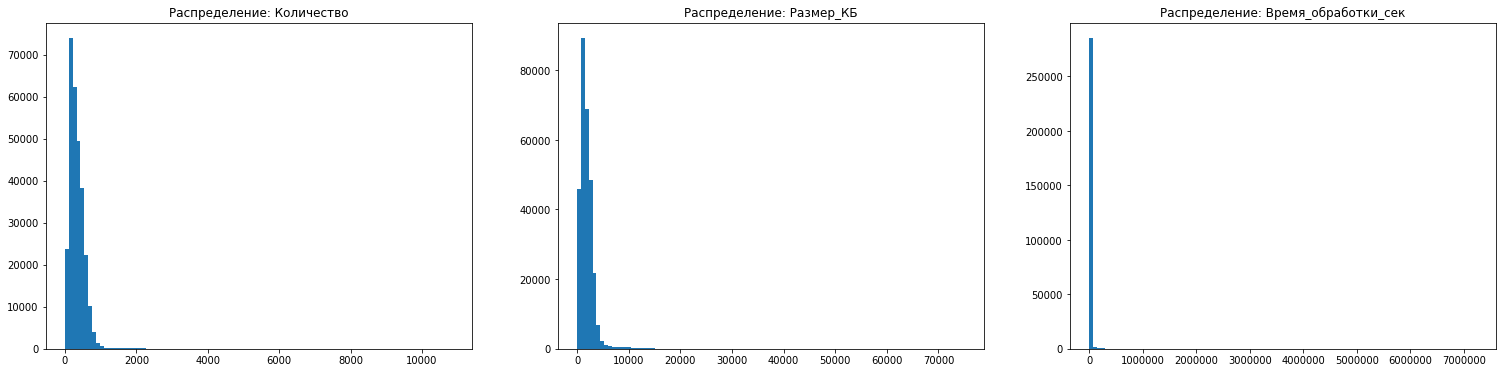

In [90]:
plt.figure(figsize=(26, 6))
for i in enumerate(['Количество','Размер_КБ','Время_обработки_сек']):
    plt.subplot(1, 3, i[0] + 1)
    plt.hist(docs[docs['DocType']=='TRANSFERTOSHOP'][i[1]], bins=100)
    plt.title('Распределение: {}'.format(i[1]))

Видим аномальное распределение по времени обработки. Следует исключить выбросы.  
Берем 95 процентиль, остальное отбрасываем.

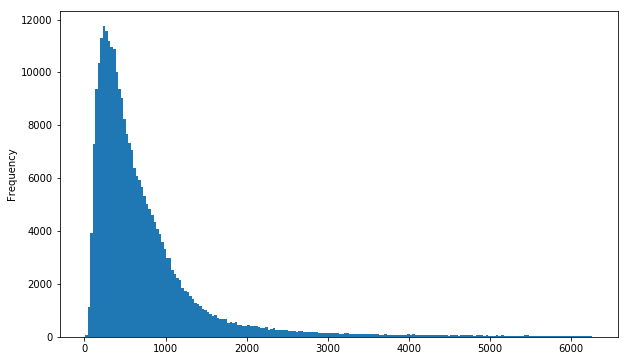

In [91]:
docs[(docs['DocType']=='TRANSFERTOSHOP') & (docs.Время_обработки_сек<=np.percentile(docs.Время_обработки_сек, 95))].Время_обработки_сек.plot(kind='hist', bins=200, figsize=(10,6));

In [92]:
TransferToShop = docs[(docs['DocType']=='TRANSFERTOSHOP') & (docs.Время_обработки_сек<=np.percentile(docs.Время_обработки_сек, 95))]

### Отбросили аномалии и пытаемся разглядеть зависимость между факторами и целевой переменной.  Зависимость пытаемся описать с помощью полиномиальной функции 3-го порядка

### Диаграмма рассеивания позволяет увидеть зависимость между двумя переменными. Зависимость апроксимируется с помощь полиномиальной функции и оценивается с помощью коэффициента R-квадрат.

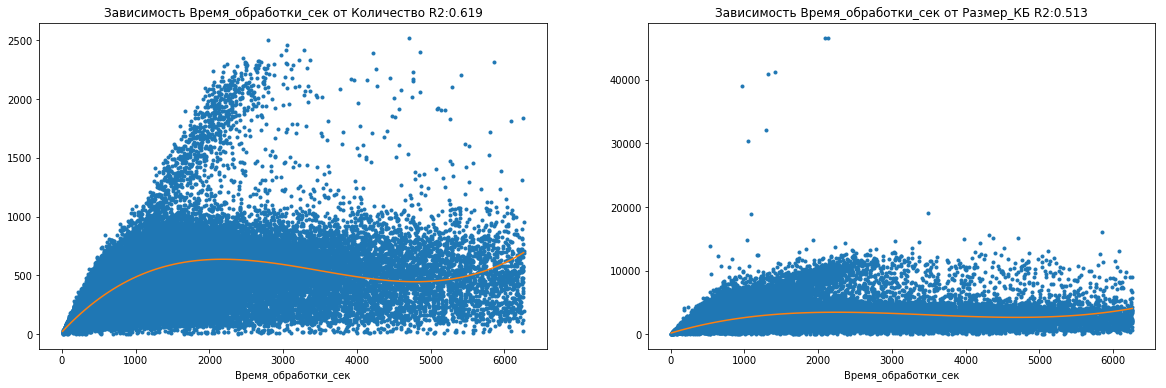

In [93]:
from sklearn import metrics
plt.figure(figsize=(20, 6))
for i in enumerate(['Количество','Размер_КБ']):
    
    x = TransferToShop.Время_обработки_сек
    y = TransferToShop[i[1]]
    z = np.polyfit(x, y,  3)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)
    
    plt.subplot(1, 2, i[0] + 1)  
    plt.plot(x, y, '.', xp, p(xp), '-')
    plt.title('Зависимость {} от {} R2:{}'.format('Время_обработки_сек', i[1],metrics.r2_score(y, p(x)).round(3) ))
    plt.xlabel('Время_обработки_сек')

### Визуально зависимость так же можно разглядеть на линейном графике 

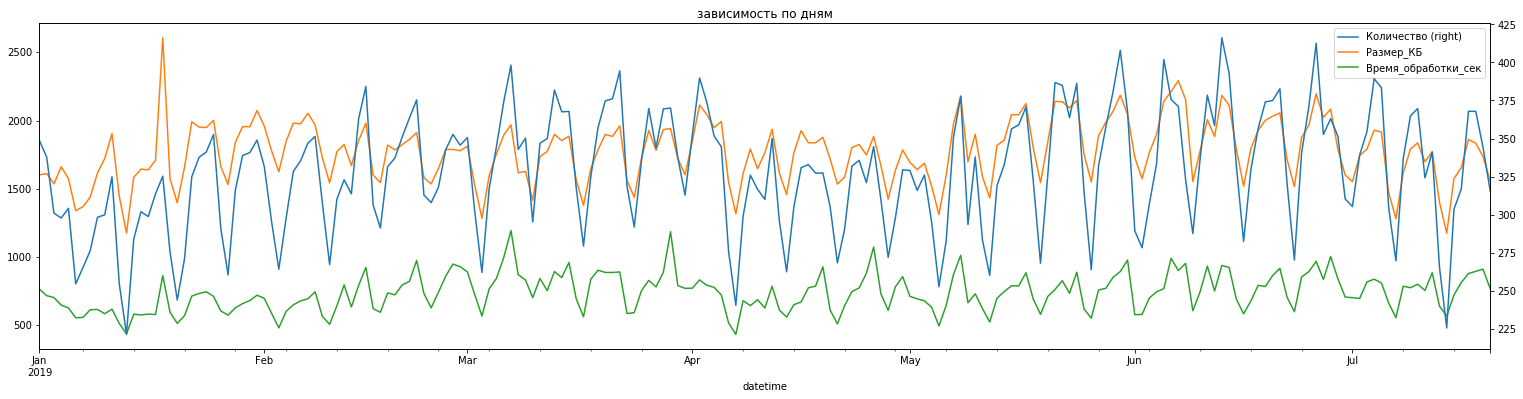

In [94]:
TransferToShop.set_index('datetime').resample('D').mean()[['Количество','Размер_КБ','Время_обработки_сек']].plot(figsize=(26, 6), title='зависимость по дням', secondary_y='Количество');

## Корреляция между количеством и размером

In [95]:
from scipy import stats
print( 'Корреляция между количеством и размером {}'.format(stats.pearsonr(TransferToShop.Количество , TransferToShop.Размер_КБ)[0].round(3))  )
print( 'Корреляция между количеством и временем обработки {}'.format(stats.pearsonr(TransferToShop.Количество , TransferToShop.Время_обработки_сек)[0].round(3))  )
print( 'Корреляция между размером и временем обработки {}'.format(stats.pearsonr(TransferToShop.Размер_КБ , TransferToShop.Время_обработки_сек)[0].round(3))  )

Корреляция между количеством и размером 0.853
Корреляция между количеством и временем обработки 0.577
Корреляция между размером и временем обработки 0.544


## Строим полиномиальную линейную регрессию 1-го порядка, по двум факторам, по дням

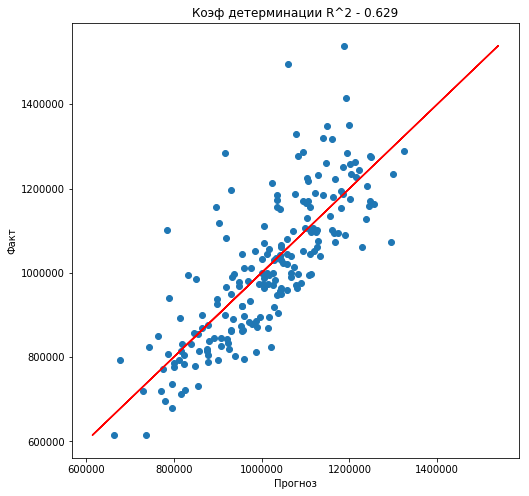

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

TransferToShop_by_day = TransferToShop.set_index('datetime').resample('D').sum()
X = TransferToShop_by_day[['Размер_КБ', 'Количество']]
y = TransferToShop_by_day['Время_обработки_сек']

# poly = PolynomialFeatures(3)
# X = poly.fit_transform(X)

reg = LinearRegression().fit(X, y)

plt.figure(figsize=(8,8))
plt.plot(x=reg.predict(X), y=y)
plt.plot(y,y, color ='r')
plt.scatter(x=reg.predict(X), y=y)
plt.title('Коэф детерминации R^2 - {}'.format(reg.score(X, y).round(3)))
plt.xlabel('Прогноз')
plt.ylabel('Факт');

## Смотрим качество прогноза. Сравниваем с реальностью

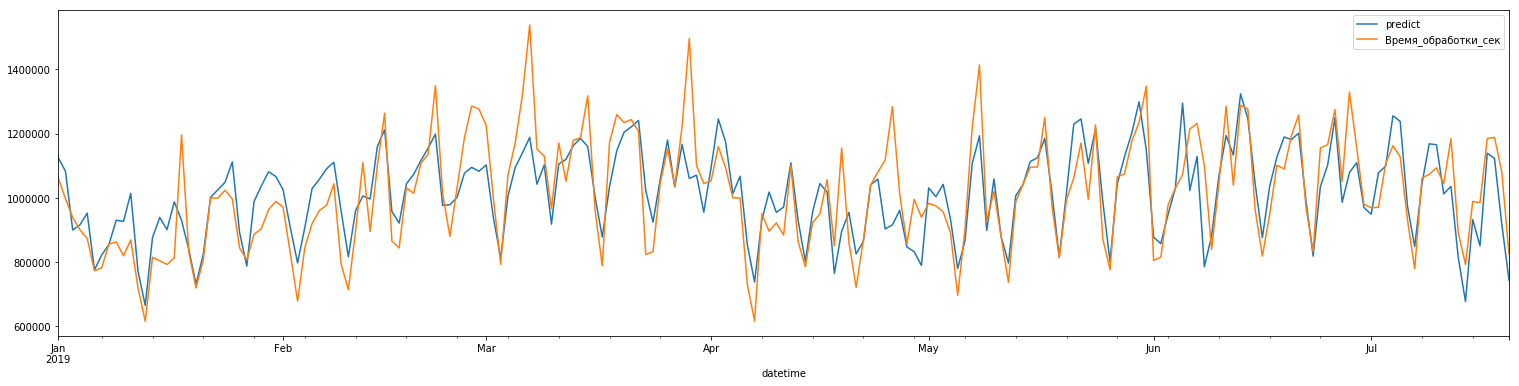

In [97]:
TransferToShop_by_day['predict'] = reg.predict(X)
TransferToShop_by_day[['predict', 'Время_обработки_сек']].plot(figsize=(26, 6));

In [98]:
import plotly.graph_objects as go

TransferToShop_by_day['Прогноз'] = reg.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=TransferToShop_by_day.index, y=TransferToShop_by_day['Время_обработки_сек'],
                    mode='lines',
                    name='Факт'))
fig.add_trace(go.Scatter(x=TransferToShop_by_day.index, y=TransferToShop_by_day['Прогноз'],
                    mode='lines',
                    name='Прогноз'))
fig.show();

## Корреляция между прогнозом и фактом

In [99]:
stats.pearsonr(TransferToShop_by_day.Время_обработки_сек, TransferToShop_by_day.Прогноз)[0]

0.7929837258892497

# ActWriteOffShop_v2 (Акт_списания_магазин_в2)

 По той же схеме

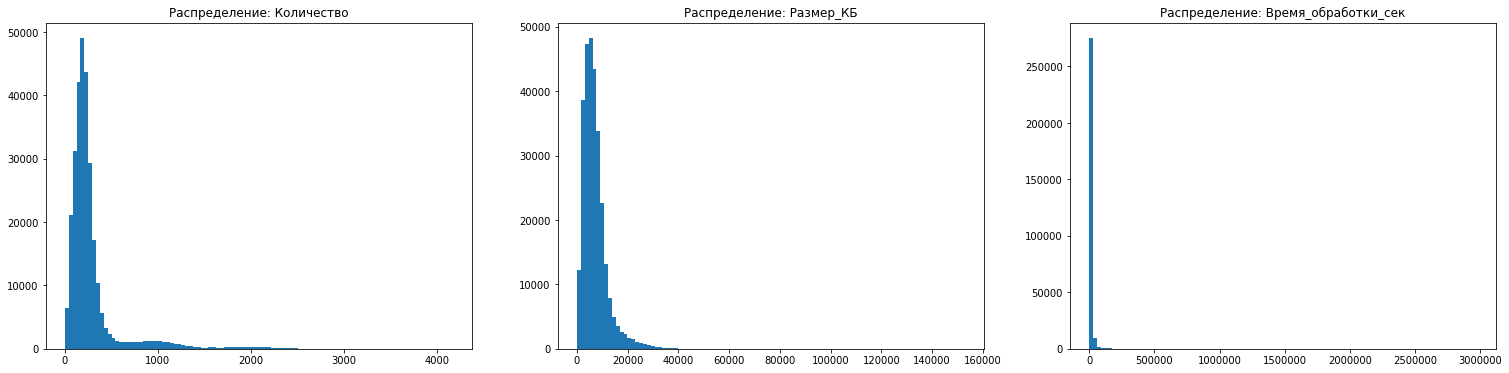

In [100]:
plt.figure(figsize=(26, 6))
for i in enumerate(['Количество','Размер_КБ','Время_обработки_сек']):
    plt.subplot(1, 3, i[0] + 1)
    plt.hist(docs[docs['DocType']=='ACTWRITEOFFSHOP_V2'][i[1]], bins=100)
    plt.title('Распределение: {}'.format(i[1]))

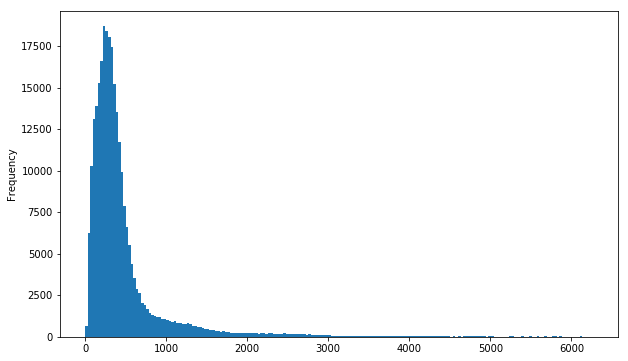

In [101]:
ActWriteOffShop_v2 = docs[(docs['DocType']=='ACTWRITEOFFSHOP_V2') & (docs.Время_обработки_сек<=np.percentile(docs.Время_обработки_сек, 95))]
ActWriteOffShop_v2.Время_обработки_сек.plot(kind='hist', bins=200, figsize=(10,6));

In [102]:
ActWriteOffShop_v2.head(2)

datetime             DocType  Количество  Размер_КБ  \
2  2019-02-05 18:46:00  ACTWRITEOFFSHOP_V2         247       3951   
26 2019-07-20 08:38:00  ACTWRITEOFFSHOP_V2         181       5889   

    Время_обработки_сек                 Документ  
2                   224  Акт_списания_магазин_в2  
26                  308  Акт_списания_магазин_в2

In [103]:
import itertools
combo = list(itertools.product(['15T', '30T', 'H', '4H', '12H', 'D'], ['Количество','Размер_КБ'] ))
combo

[('15T', 'Количество'),
 ('15T', 'Размер_КБ'),
 ('30T', 'Количество'),
 ('30T', 'Размер_КБ'),
 ('H', 'Количество'),
 ('H', 'Размер_КБ'),
 ('4H', 'Количество'),
 ('4H', 'Размер_КБ'),
 ('12H', 'Количество'),
 ('12H', 'Размер_КБ'),
 ('D', 'Количество'),
 ('D', 'Размер_КБ')]

### Для улучшения качества восстановления зависимости попробуем подобрать более подходящий временной интервал, для этого осуществим перебор каждого из 2 предикторов (переменные по которым восстанавливается зависимость в нашем случае это количество документов и их объем) по интервалам '15 мин', '30 мин', '1 час', '4 часа', '12 часов', '1 день'

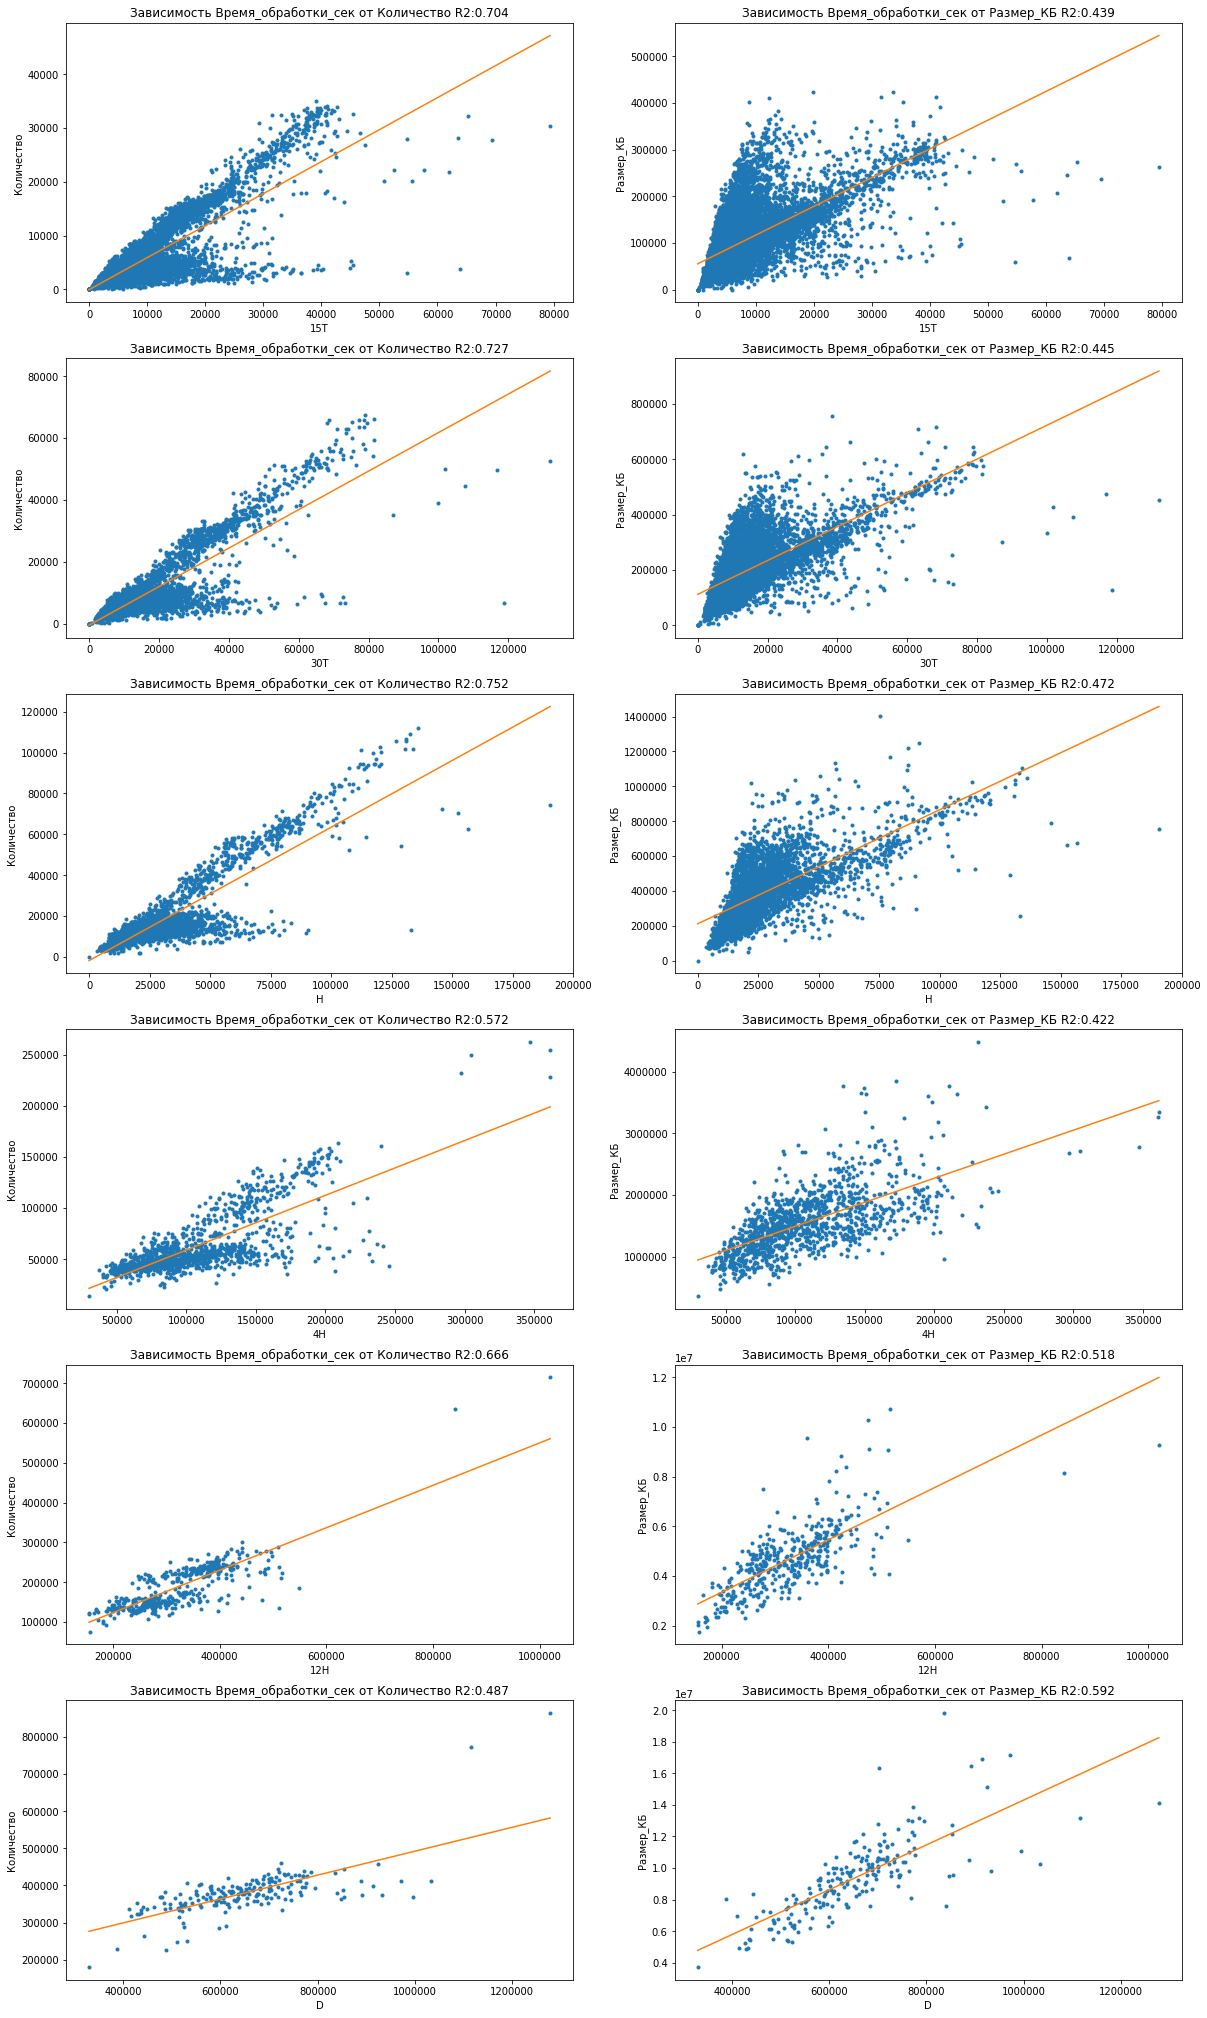

In [104]:
plt.figure(figsize=(20, 36))
# ActWriteOffShop_v2.set_index('datetime', inplace=True)
for i,t in enumerate(combo):

    x = ActWriteOffShop_v2.set_index('datetime').resample(t[0]).sum()['Время_обработки_сек']
    y = ActWriteOffShop_v2.set_index('datetime').resample(t[0]).sum()[t[1]]
    z = np.polyfit(x, y,  1)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)

    plt.subplot(6, 2, i + 1)  
    plt.plot(x, y, '.', xp, p(xp), '-')
    plt.title('Зависимость {} от {} R2:{}'.format('Время_обработки_сек', t[1],metrics.r2_score(y, p(x)).round(3) ))
    plt.ylabel(t[1])
    plt.xlabel(t[0])

### Лучше всего зависимость восстанавиливается на временном интервале 1 час.

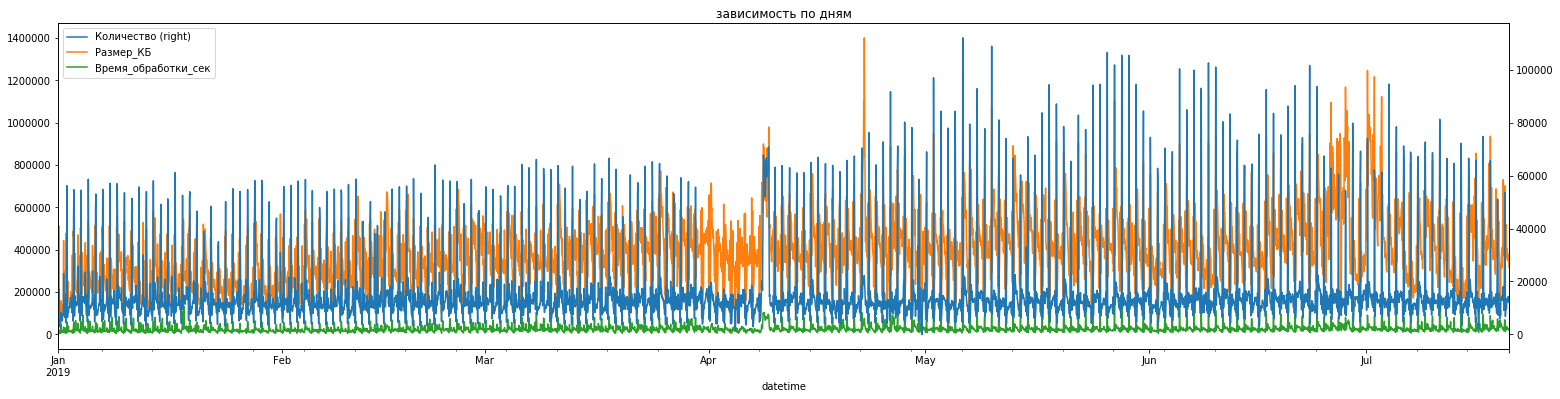

In [105]:
ActWriteOffShop_v2.set_index('datetime').resample('H').sum().plot(figsize=(26, 6), title='зависимость по дням', secondary_y='Количество');

In [106]:
from scipy import stats
print('Корреляция:\nВремени с количеством: {}\nВремени с размером: {} '.format(stats.pearsonr(ActWriteOffShop_v2.Количество , ActWriteOffShop_v2.Время_обработки_сек)[0].round(3), 
                                                                             stats.pearsonr(ActWriteOffShop_v2.Размер_КБ , ActWriteOffShop_v2.Время_обработки_сек)[0].round(3)))

Корреляция:
Времени с количеством: 0.653
Времени с размером: 0.51 


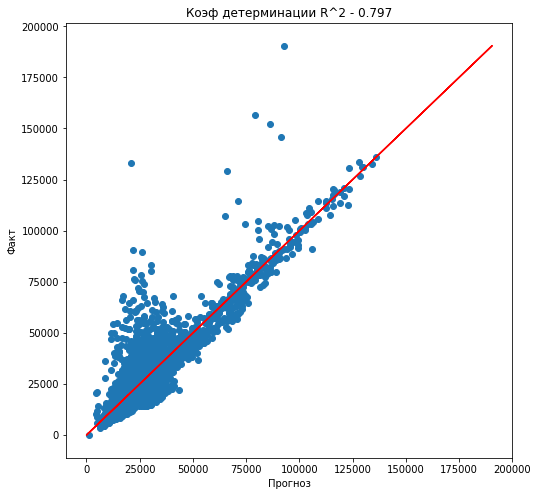

In [107]:
ActWriteOffShop_v2_by_day = ActWriteOffShop_v2.set_index('datetime').resample('1H').sum()
X = ActWriteOffShop_v2_by_day[['Размер_КБ', 'Количество']]
y = ActWriteOffShop_v2_by_day['Время_обработки_сек']

# poly = PolynomialFeatures(1)
# X = poly.fit_transform(X)

reg = LinearRegression().fit(X, y)

plt.figure(figsize=(8,8))
plt.plot(x=reg.predict(X), y=y)
plt.plot(y,y, color ='r')
plt.scatter(x=reg.predict(X), y=y)
plt.title('Коэф детерминации R^2 - {}'.format(reg.score(X, y).round(3)))
plt.xlabel('Прогноз')
plt.ylabel('Факт');

### Качество восстановления зависимости достикает коэффициента детерминации R-квадрат 0,79. Сравним восстановленные значения с фактическими визуально

In [108]:
ActWriteOffShop_v2_by_day['Прогноз'] = reg.predict(X)
fig = go.Figure()
fig.add_trace(go.Scatter(x=ActWriteOffShop_v2_by_day.index, y=ActWriteOffShop_v2_by_day['Время_обработки_сек'],
                    mode='lines',
                    name='Факт'))
fig.add_trace(go.Scatter(x=ActWriteOffShop_v2_by_day.index, y=ActWriteOffShop_v2_by_day['Прогноз'],
                    mode='lines',
                    name='Прогноз'))
fig.show();

# Акт по накладной в3 (WAYBILL_V3)

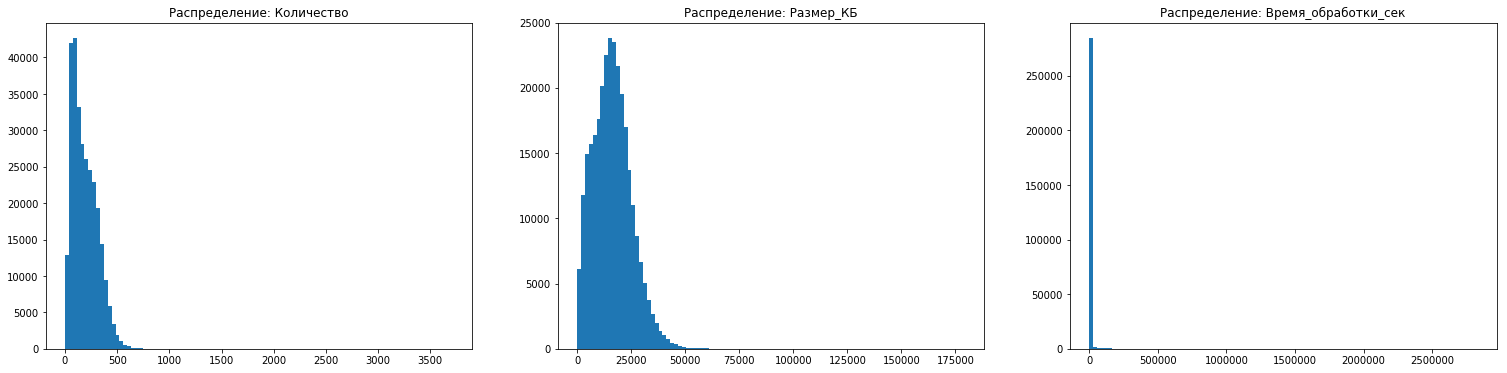

In [109]:
plt.figure(figsize=(26, 6))
for i in enumerate(['Количество','Размер_КБ','Время_обработки_сек']):
    plt.subplot(1, 3, i[0] + 1)
    plt.hist(docs[docs['DocType']=='WAYBILL_V3'][i[1]], bins=100)
    plt.title('Распределение: {}'.format(i[1]))

Видим аномальное распределение по времени обработки. Следует исключить выбросы.  
Берем 95 процентиль, остальное отбрасываем.

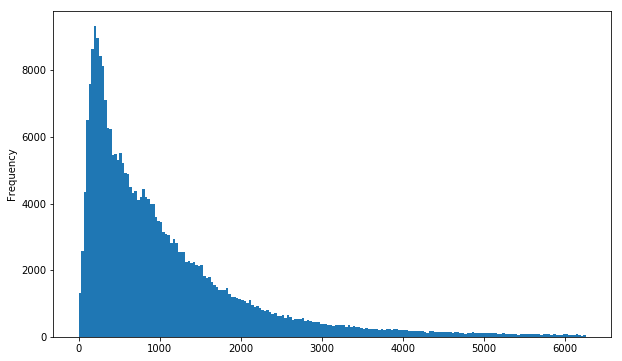

In [110]:
docs[(docs['DocType']=='WAYBILL_V3') & (docs.Время_обработки_сек<=np.percentile(docs.Время_обработки_сек, 95))].Время_обработки_сек.plot(kind='hist', bins=200, figsize=(10,6));

In [111]:
WayBill_v3 = docs[(docs['DocType']=='WAYBILL_V3') & (docs.Время_обработки_сек<=np.percentile(docs.Время_обработки_сек, 95))]

### Отбросили аномалии и пытаемся разглядеть зависимость между факторами и целевой переменной

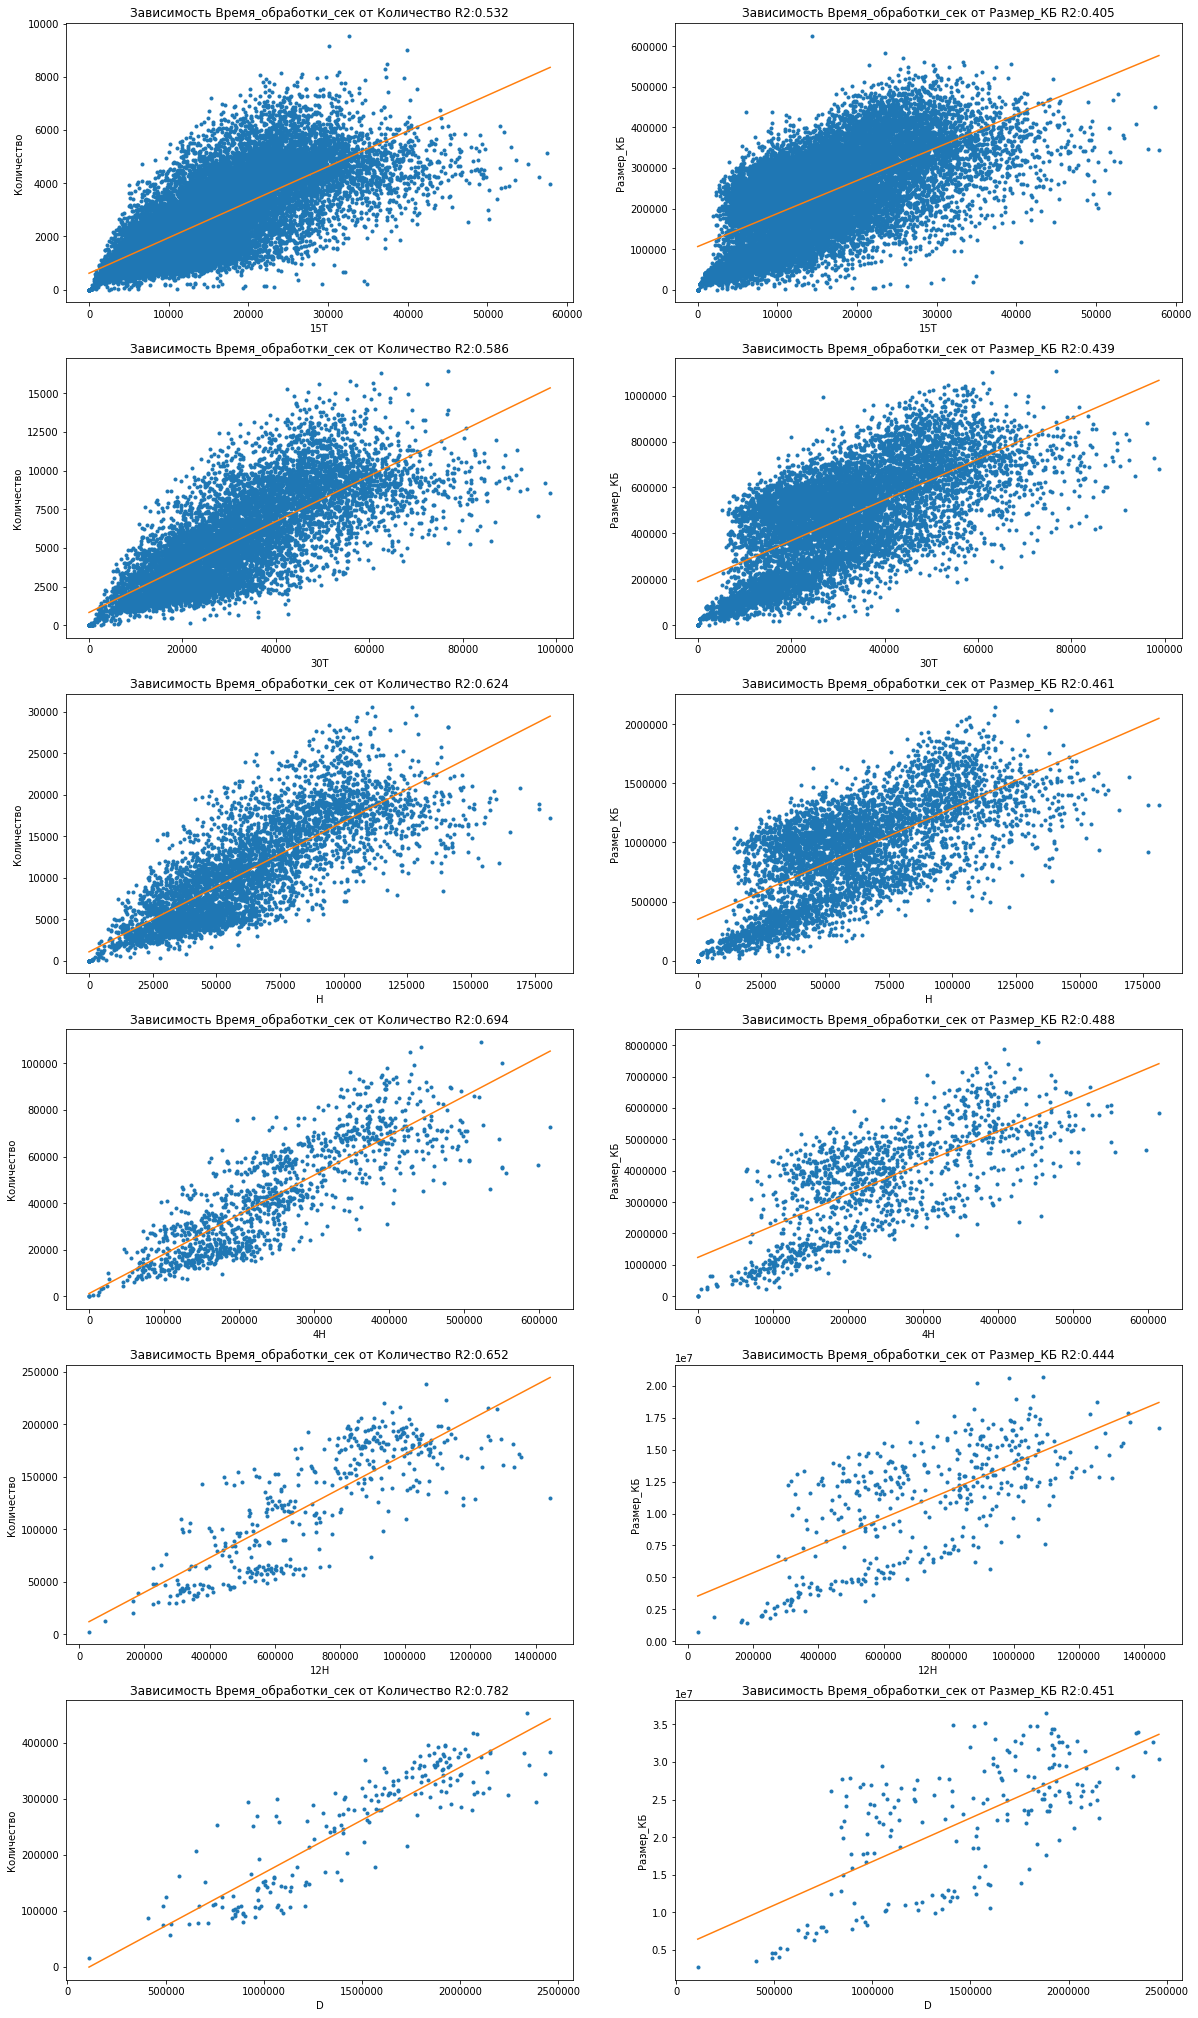

In [112]:
plt.figure(figsize=(20, 36))
WayBill_v3.set_index('datetime', inplace=True)
for i,t in enumerate(combo):

    x = WayBill_v3.resample(t[0]).sum()['Время_обработки_сек']
    y = WayBill_v3.resample(t[0]).sum()[t[1]]
    z = np.polyfit(x, y,  1)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)

    plt.subplot(6, 2, i + 1)  
    plt.plot(x, y, '.', xp, p(xp), '-')
    plt.title('Зависимость {} от {} R2:{}'.format('Время_обработки_сек', t[1],metrics.r2_score(y, p(x)).round(3) ))
    plt.ylabel(t[1])
    plt.xlabel(t[0])

## Строим линейную регрессию по двум факторам

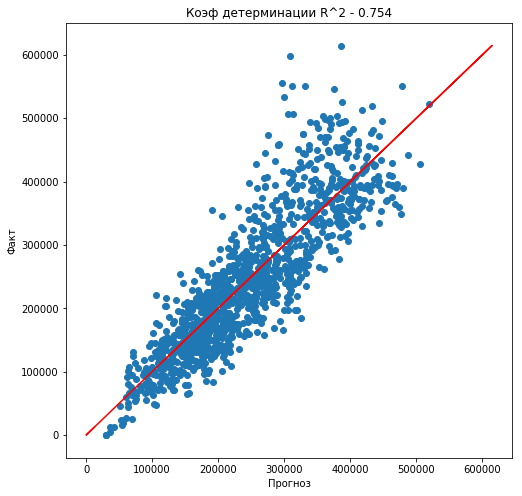

In [113]:
WayBill_v3_by_day = WayBill_v3.resample('4H').sum()
X = WayBill_v3_by_day[['Размер_КБ', 'Количество']]
y = WayBill_v3_by_day['Время_обработки_сек']

# poly = PolynomialFeatures(2)
# X = poly.fit_transform(X)

reg = LinearRegression().fit(X, y)

plt.figure(figsize=(8,8))
plt.plot(x=reg.predict(X), y=y)
plt.plot(y,y, color ='r')
plt.scatter(x=reg.predict(X), y=y)
plt.title('Коэф детерминации R^2 - {}'.format(reg.score(X, y).round(3)))
plt.xlabel('Прогноз')
plt.ylabel('Факт');

## Смотрим качество прогноза. Сравниваем с реальностью

In [114]:
WayBill_v3_by_day['Прогноз'] = reg.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=WayBill_v3_by_day.index, y=WayBill_v3_by_day['Время_обработки_сек'],
                    mode='lines',
                    name='Факт'))
fig.add_trace(go.Scatter(x=WayBill_v3_by_day.index, y=WayBill_v3_by_day['Прогноз'],
                    mode='lines',
                    name='Прогноз'))
fig.show();

# AsiiuTimesign (Счетчики 5 мин.)

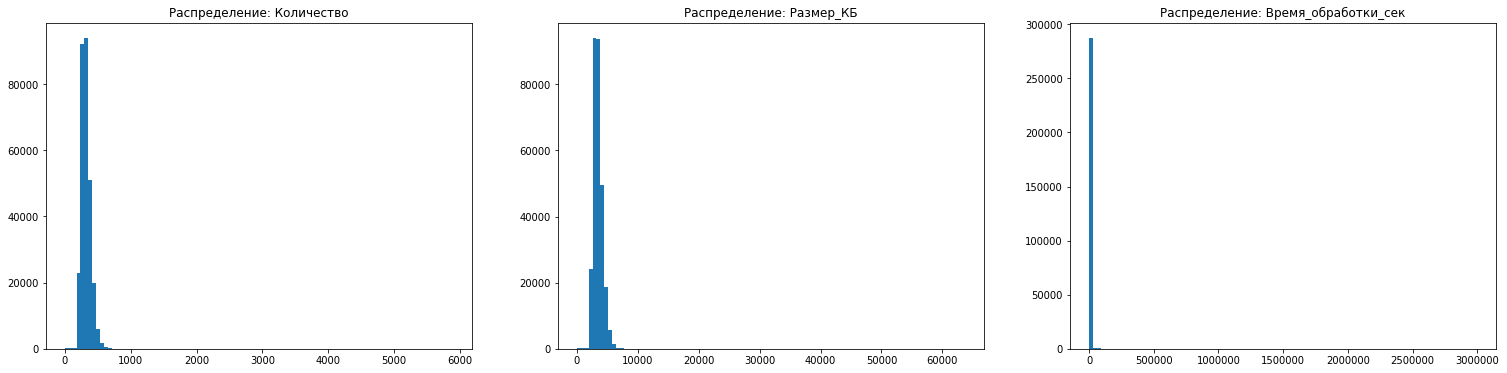

In [115]:
plt.figure(figsize=(26, 6))
for i in enumerate(['Количество','Размер_КБ','Время_обработки_сек']):
    plt.subplot(1, 3, i[0] + 1)
    plt.hist(docs[docs['DocType']=='ASIIUTIMESIGN'][i[1]], bins=100)
    plt.title('Распределение: {}'.format(i[1]))

Видим аномальное распределение по времени обработки. Следует исключить выбросы.  
Берем 95 процентиль, остальное отбрасываем.

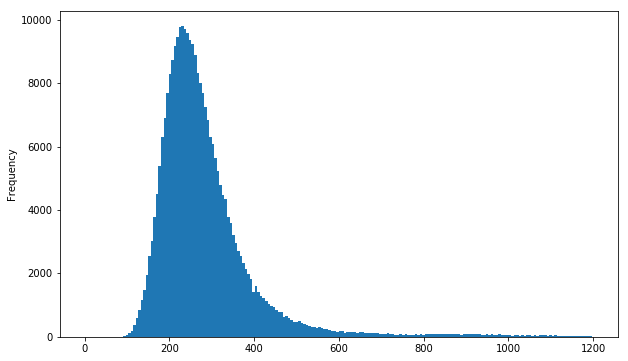

In [116]:
docs[(docs['DocType']=='ASIIUTIMESIGN') & (docs.Время_обработки_сек<=np.percentile(docs.Время_обработки_сек, 90))].Время_обработки_сек.plot(kind='hist', bins=200, figsize=(10,6));

In [117]:
AsiiuTimesign = docs[(docs['DocType']=='ASIIUTIMESIGN') & (docs.Время_обработки_сек<=np.percentile(docs.Время_обработки_сек, 90))]

### Отбросили аномалии и пытаемся разглядеть зависимость между факторами и целевой переменной

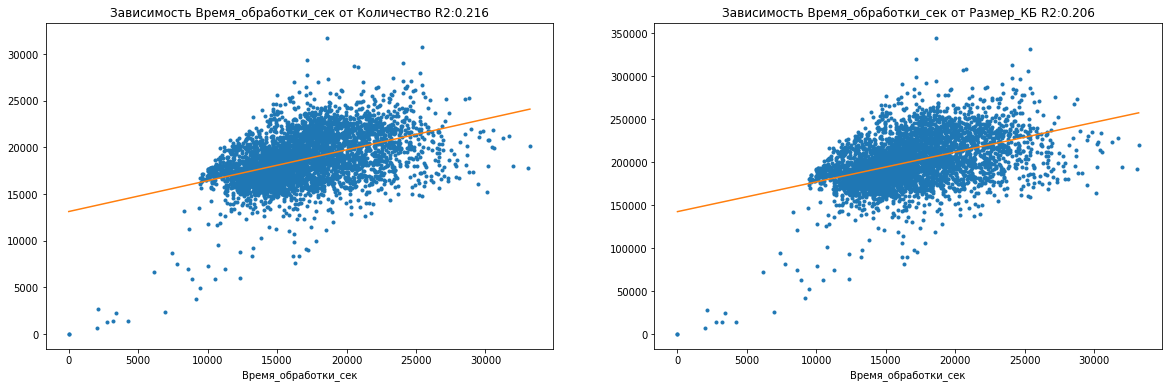

In [118]:
AsiiuTimesign_by_t = AsiiuTimesign.set_index('datetime').resample(' H').sum()

plt.figure(figsize=(20, 6))
for i in enumerate(['Количество','Размер_КБ']):
    
    x = AsiiuTimesign_by_t.Время_обработки_сек
    y = AsiiuTimesign_by_t[i[1]]
    z = np.polyfit(x, y,  1)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)
    
    plt.subplot(1, 2, i[0] + 1)  
    plt.plot(x, y, '.', xp, p(xp), '-')
    plt.title('Зависимость {} от {} R2:{}'.format('Время_обработки_сек', i[1],metrics.r2_score(y, p(x)).round(3) ))
    plt.xlabel('Время_обработки_сек')

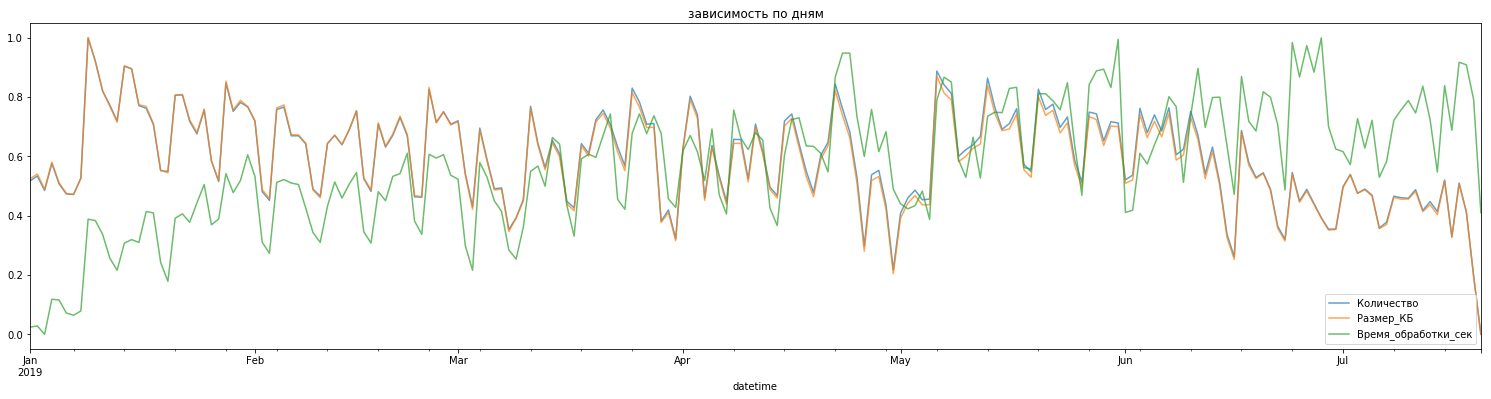

In [119]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

AsiiuTimesign_by_day = AsiiuTimesign.set_index('datetime').resample('D').sum()

AsiiuTimesign_by_day[['Количество','Размер_КБ','Время_обработки_сек']] = scaler.fit_transform(AsiiuTimesign_by_day.astype(float))
AsiiuTimesign_by_day.plot(figsize=(26, 6), alpha=0.7, title='зависимость по дням');

### размер с количеством коррелирует идеально, потому что размер документов АСИИУ ничножно мал. Но со временем обработки корреляция почти отсутствует, т.к. оно зависит от других документов.

In [120]:
from scipy import stats
print(stats.pearsonr(AsiiuTimesign_by_day.Количество , AsiiuTimesign_by_day.Размер_КБ)[0])
print(stats.pearsonr(AsiiuTimesign_by_day.Количество , AsiiuTimesign_by_day.Время_обработки_сек)[0])

0.9984743240272898
0.15616029428670236


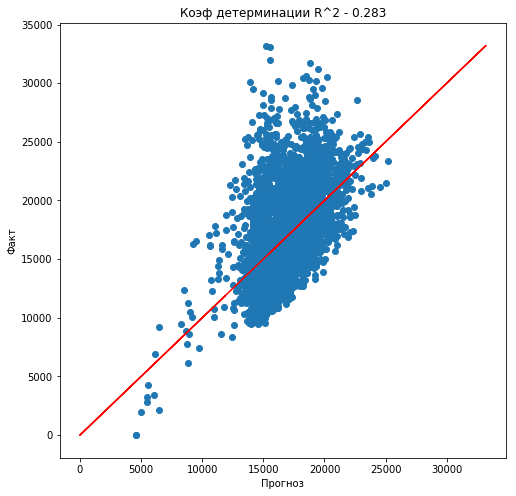

In [121]:
# AsiiuTimesign_by_day = AsiiuTimesign.groupby('date')['qnt','CurrSize_kb','ProcessingTime_sec'].sum().reset_index()
X = AsiiuTimesign_by_t[['Размер_КБ', 'Количество']]
y = AsiiuTimesign_by_t['Время_обработки_сек']

# poly = PolynomialFeatures(3)
# X = poly.fit_transform(X)

reg = LinearRegression().fit(X, y)

plt.figure(figsize=(8,8))
plt.plot(x=reg.predict(X), y=y)
plt.plot(y,y, color ='r')
plt.scatter(x=reg.predict(X), y=y)
plt.title('Коэф детерминации R^2 - {}'.format(reg.score(X, y).round(3)))
plt.xlabel('Прогноз')
plt.ylabel('Факт');

## Скорость обработки документа AsiiuTimesign (показатели счетчика 5 минутный интервал) не зависит от количества и объема, а скорре от состояния системы, то есть от нагрузки другими документами, т.к. этот документ поступает в утм регулярно и равномерно в автоматическом режиме.

# WayBillAct_v3 (Акт по накладной)

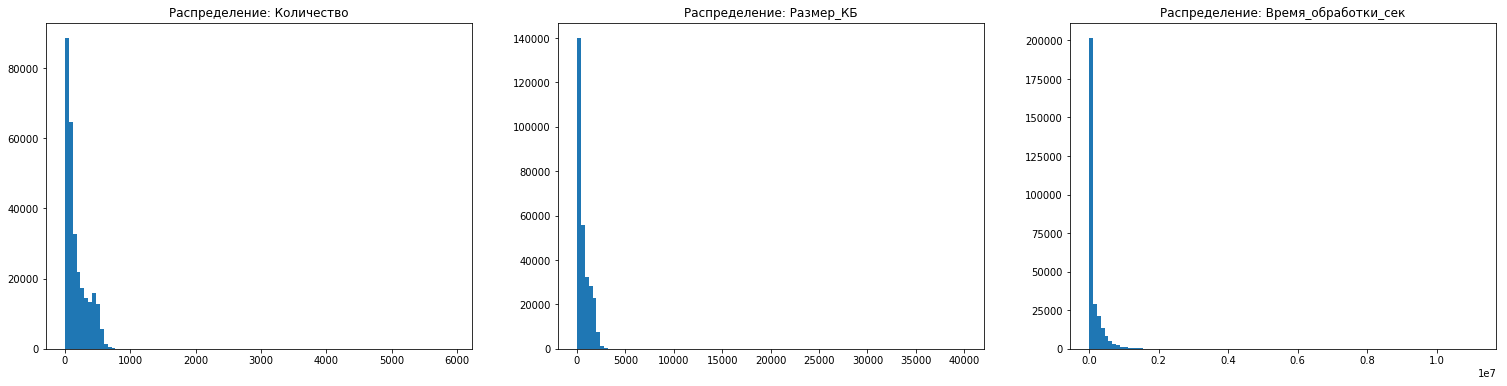

In [122]:
plt.figure(figsize=(26, 6))
for i in enumerate(['Количество','Размер_КБ','Время_обработки_сек']):
    plt.subplot(1, 3, i[0] + 1)
    plt.hist(docs[docs['DocType']=='WAYBILLACT_V3'][i[1]], bins=100)
    plt.title('Распределение: {}'.format(i[1]))

Видим аномальное распределение по времени обработки. Следует исключить выбросы.  
Берем 95 процентиль, остальное отбрасываем.

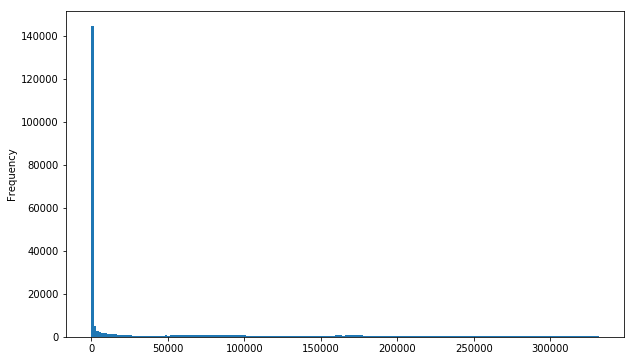

In [123]:
docs[(docs['DocType']=='WAYBILLACT_V3') & (docs.Время_обработки_сек<=np.percentile(docs.Время_обработки_сек, 99))].Время_обработки_сек.plot(kind='hist', bins=200, figsize=(10,6));

In [124]:
WayBillAct_v3 = docs[(docs['DocType']=='WAYBILLACT_V3') & (docs.Время_обработки_сек<=np.percentile(docs.Время_обработки_сек, 99))]

### Отбросили аномалии и пытаемся разглядеть зависимость между факторами и целевой переменной

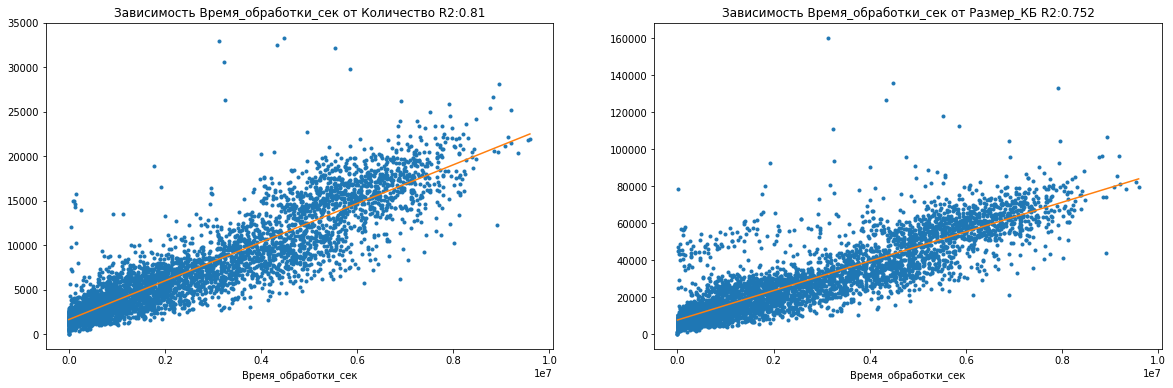

In [125]:
WayBillAct_v3_t = WayBillAct_v3.set_index('datetime').resample('H').sum()
plt.figure(figsize=(20, 6))
for i in enumerate(['Количество','Размер_КБ']):
    
    x = WayBillAct_v3_t.Время_обработки_сек
    y = WayBillAct_v3_t[i[1]]
    z = np.polyfit(x, y,  1)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)
    
    plt.subplot(1, 2, i[0] + 1)  
    plt.plot(x, y, '.', xp, p(xp), '-')
    plt.title('Зависимость {} от {} R2:{}'.format('Время_обработки_сек', i[1],metrics.r2_score(y, p(x)).round(3) ))
    plt.xlabel('Время_обработки_сек')

In [126]:
print(p)
from sklearn import metrics
metrics.r2_score(y, p(x)).round(3)

 
0.007949 x + 7607


0.752

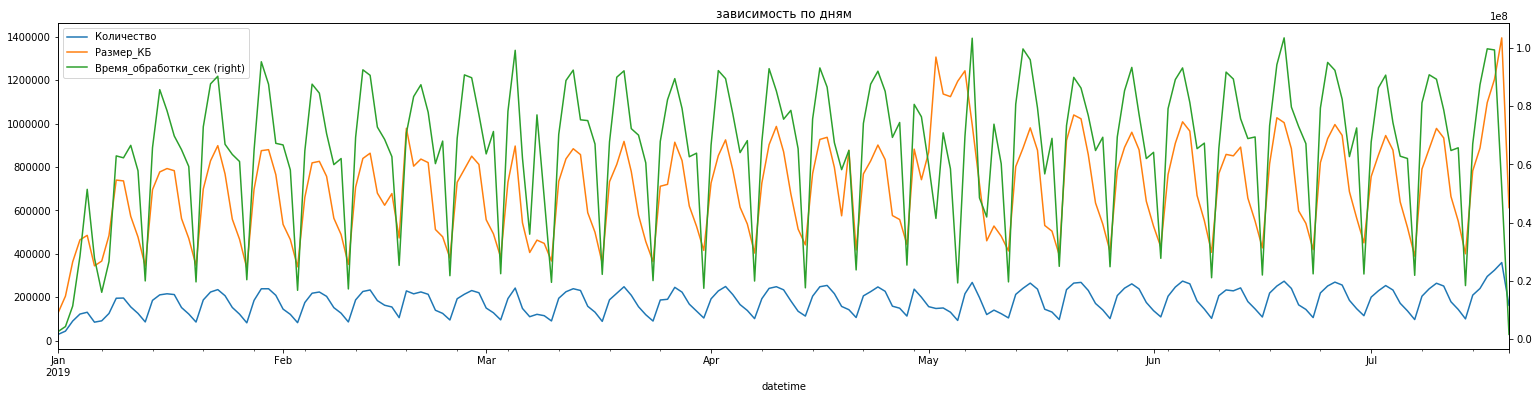

In [127]:
WayBillAct_v3.set_index('datetime').resample('D').sum().plot(figsize=(26, 6), secondary_y='Время_обработки_сек', title='зависимость по дням');

### Оба признака - количество и объем хорошо коррелируют со временем обработки

In [128]:
from scipy import stats
print(stats.pearsonr(WayBillAct_v3.Количество , WayBillAct_v3.Время_обработки_сек))
print(stats.pearsonr(WayBillAct_v3.Размер_КБ , WayBillAct_v3.Время_обработки_сек))

(0.5718028319492838, 0.0)
(0.532112810528279, 0.0)


In [129]:
# top_10.head(5).set_index('Документ').plot(kind='pie', y=['Размер_КБ', 'Количество'], subplots=True, figsize=(28,12));

## Строим полиномиальную линейную регрессию 3-го порядка, по двум факторам

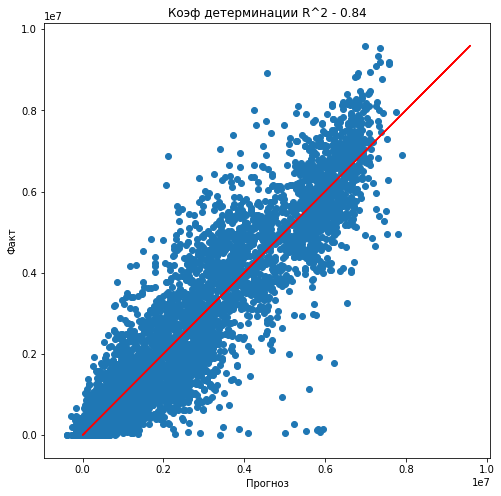

In [130]:
WayBillAct_v3_t = WayBillAct_v3.set_index('datetime').resample('H').sum()
X = WayBillAct_v3_t[['Размер_КБ', 'Количество']]
y = WayBillAct_v3_t['Время_обработки_сек']

poly = PolynomialFeatures(3)
X = poly.fit_transform(X)

reg = LinearRegression().fit(X, y)

plt.figure(figsize=(8,8))
plt.plot(x=reg.predict(X), y=y)
plt.plot(y,y, color ='r')
plt.scatter(x=reg.predict(X), y=y)
plt.title('Коэф детерминации R^2 - {}'.format(reg.score(X, y).round(3)))
plt.xlabel('Прогноз')
plt.ylabel('Факт');

In [133]:
WayBillAct_v3_t.head()

Количество  Размер_КБ  Время_обработки_сек        Прогноз
datetime                                                                      
2019-01-01 00:00:00         471       2145                64467 -163046.038289
2019-01-01 01:00:00         541       1727                 1057 -176715.692259
2019-01-01 02:00:00         600       1912                 1527 -154695.479639
2019-01-01 03:00:00         285        929                  217 -271773.338416
2019-01-01 04:00:00         284        901                  204 -273718.285112

## Смотрим качество прогноза. Сравниваем с реальностью

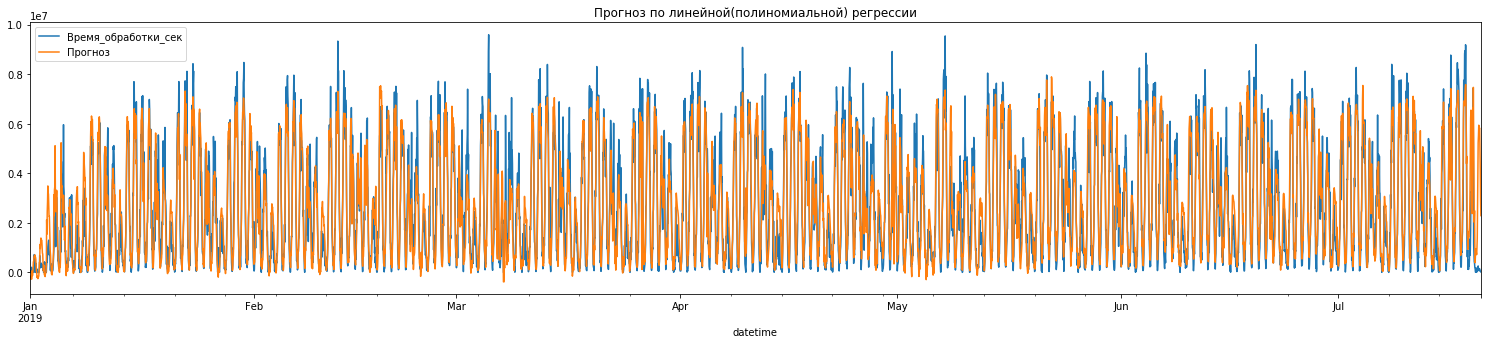

In [135]:
WayBillAct_v3_t['Прогноз'] = reg.predict(X)
WayBillAct_v3_t[['Время_обработки_сек','Прогноз']].plot(figsize=(26, 5), title='Прогноз по линейной(полиномиальной) регрессии');

In [136]:
WayBillAct_v3_t['Прогноз'] = reg.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=WayBillAct_v3_t.index, y=WayBillAct_v3_t['Время_обработки_сек'],
                    mode='lines',
                    name='Факт'))
fig.add_trace(go.Scatter(x=WayBillAct_v3_t.index, y=WayBillAct_v3_t['Прогноз'],
                    mode='lines',
                    name='Прогноз'))
fig.show();

# Общая картина (по всем 5 документам)

In [137]:
top_5_docs = docs.merge(docs.groupby(['DocType', 'Документ'])['Количество'].sum().sort_values(ascending=False).head(5).reset_index().DocType, on='DocType', how='inner')
print(top_5_docs.shape)
top_5_docs.head()

(1444305, 6)


datetime         DocType  Количество  Размер_КБ  \
0 2019-06-16 18:28:00  TRANSFERTOSHOP         214       1436   
1 2019-07-12 16:12:00  TRANSFERTOSHOP         615       2951   
2 2019-03-22 02:51:00  TRANSFERTOSHOP          77        575   
3 2019-04-03 13:33:00  TRANSFERTOSHOP         435       2793   
4 2019-04-03 17:28:00  TRANSFERTOSHOP         500       2283   

   Время_обработки_сек                Документ  
0                  418  Перемещение_в_торг_зал  
1                 7364  Перемещение_в_торг_зал  
2                  100  Перемещение_в_торг_зал  
3                  761  Перемещение_в_торг_зал  
4                 1058  Перемещение_в_торг_зал

## Отбрасываем хвосты свыше 90% квантили

In [139]:
doctypes = pd.Series(np.unique(top_5_docs.DocType))
percentiles_time = []
# percentiles_size = []
for types in doctypes:
    pd.Series(percentiles_time.append(top_5_docs.Время_обработки_сек[top_5_docs.DocType == types].quantile(0.95)))
#     pd.Series(percentiles_size.append(int(np.percentile(top_7_docs.CurrSize_kb[docs['DocType']==types], 90))))
percentile_data = pd.DataFrame(np.vstack((doctypes, percentiles_time)).T, columns=['DocType', 'perc_90_time'])
percentile_data

DocType perc_90_time
0  ACTWRITEOFFSHOP_V2        23058
1       ASIIUTIMESIGN          677
2      TRANSFERTOSHOP         4916
3       WAYBILLACT_V3       568857
4          WAYBILL_V3         5348

In [140]:
top_5_docs_90 = top_5_docs.merge(percentile_data, on='DocType', how='left')
top_5_docs_90 = top_5_docs[top_5_docs_90.Время_обработки_сек<=top_5_docs_90.perc_90_time]
top_5_docs_90.shape

(1372103, 6)

In [141]:
top_5_docs_90.head()

datetime         DocType  Количество  Размер_КБ  \
0 2019-06-16 18:28:00  TRANSFERTOSHOP         214       1436   
2 2019-03-22 02:51:00  TRANSFERTOSHOP          77        575   
3 2019-04-03 13:33:00  TRANSFERTOSHOP         435       2793   
4 2019-04-03 17:28:00  TRANSFERTOSHOP         500       2283   
5 2019-06-25 06:54:00  TRANSFERTOSHOP         332       1386   

   Время_обработки_сек                Документ  
0                  418  Перемещение_в_торг_зал  
2                  100  Перемещение_в_торг_зал  
3                  761  Перемещение_в_торг_зал  
4                 1058  Перемещение_в_торг_зал  
5                  382  Перемещение_в_торг_зал

In [ ]:
# top_5_docs_90_t = top_5_docs_90.set_index(['datetime', 'Документ']).resample('H').sum()
# top_5_docs_90_t.head()

## Сравниваем распределение значений пяти документов между собой по количеству, размеру и времени обработки

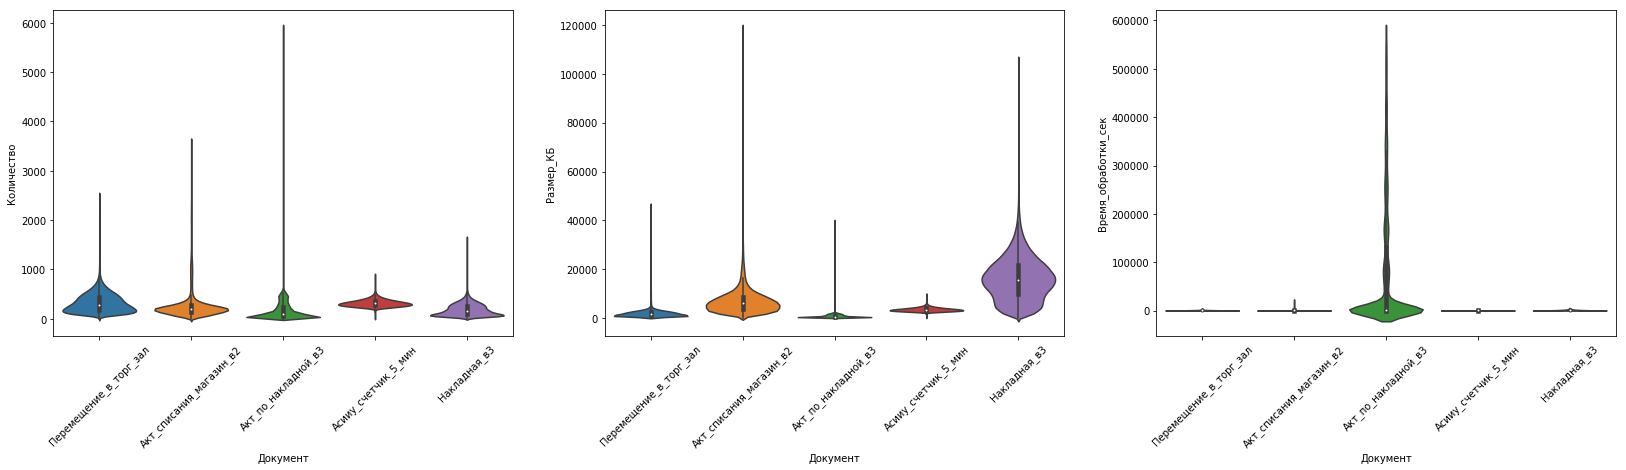

In [142]:
import seaborn as sns
plt.figure(figsize=(28, 6))
for i in enumerate(['Количество','Размер_КБ','Время_обработки_сек']):
    plt.subplot(1, 3, i[0] + 1)
    ax = sns.violinplot(x="Документ", y=i[1], data=top_5_docs_90, rotation = 90, scale = 'width' )
    plt.xticks(rotation=45)

# Как видно из распределения по времени обработки документа "Акт по накладной", скорость их обработки сильно варьируется, что может объясняться ручной обработкой, поэтому данный вид документа не может участвовать в анализе наряду с другими документами.

In [150]:
top_4_docs_90 = top_5_docs_90[top_5_docs_90['DocType']!='WAYBILLACT_V3']
top_4_docs_90.shape

(1097761, 6)

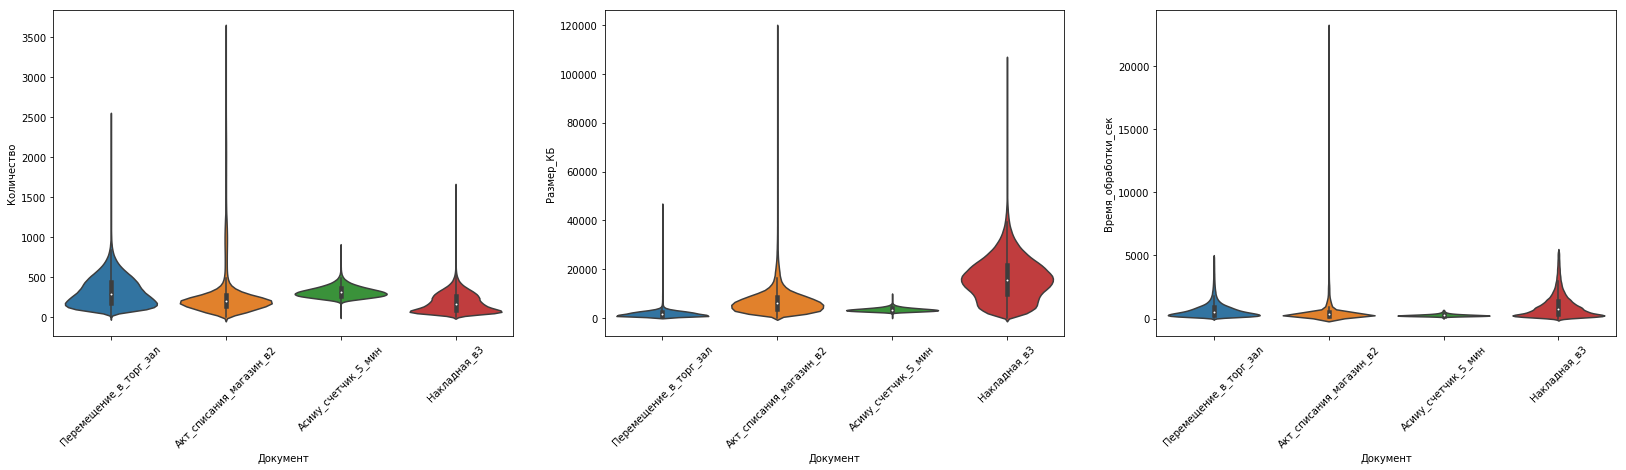

In [151]:
plt.figure(figsize=(28, 6))
for i in enumerate(['Количество','Размер_КБ','Время_обработки_сек']):
    plt.subplot(1, 3, i[0] + 1)
    ax = sns.violinplot(x="Документ", y=i[1], data=top_4_docs_90, rotation = 90, scale = 'width' )
    plt.xticks(rotation=45)

## Суммируем данные по всем 4 документам, группируем по 1 часу

In [145]:
top_4_docs_90_gropp_H = top_4_docs_90.set_index('datetime').resample('H').sum()

### Смотрим зависимость между факторами и целевой переменной по всем 4 документам вместе

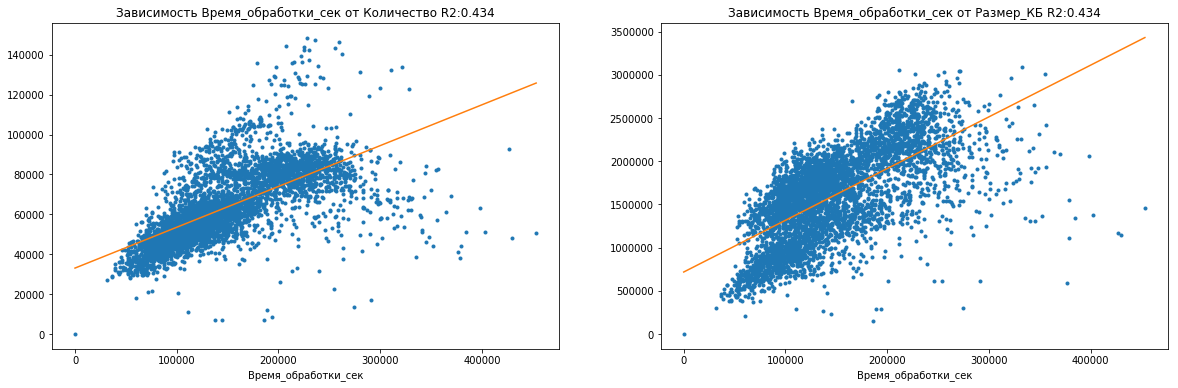

In [152]:
plt.figure(figsize=(20, 6))
for i in enumerate(['Количество','Размер_КБ']):
    
    x = top_4_docs_90_gropp_H.Время_обработки_сек
    y = top_4_docs_90_gropp_H[i[1]]
    z = np.polyfit(x, y,  1)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)
    
    plt.subplot(1, 2, i[0] + 1)  
    plt.plot(x, y, '.', xp, p(xp), '-')
    plt.title('Зависимость {} от {} R2:{}'.format('Время_обработки_сек', i[1],metrics.r2_score(y, p(x)).round(3) ))
    plt.xlabel('Время_обработки_сек')

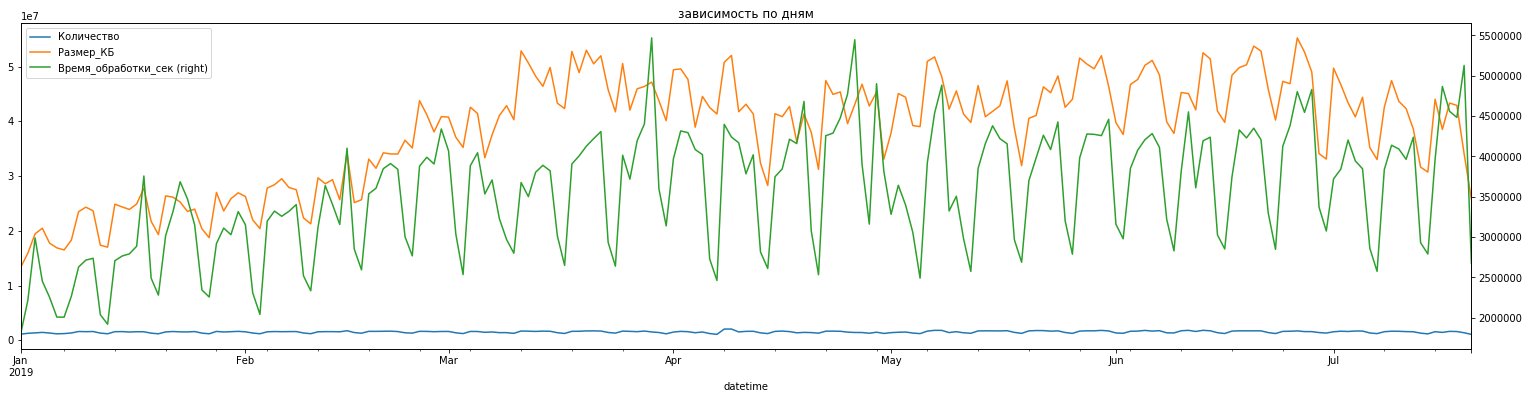

In [153]:
top_4_docs_90_gropp_H.resample('D').sum().plot(figsize=(26, 6), title='зависимость по дням', secondary_y='Время_обработки_сек');

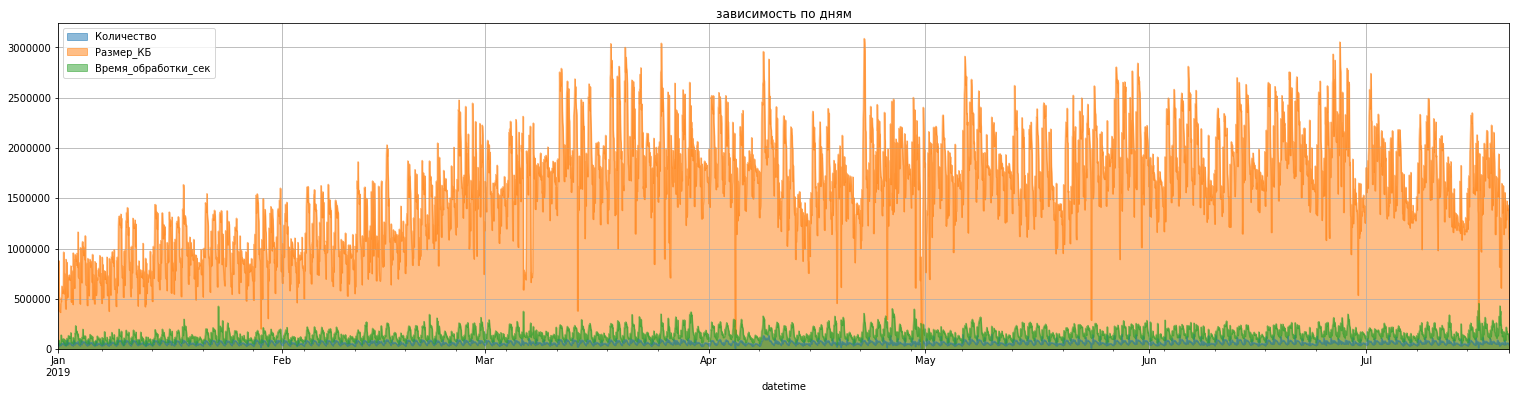

In [154]:
top_4_docs_90_gropp_H.groupby('datetime')['Количество','Размер_КБ','Время_обработки_сек'].sum().plot(kind='area',figsize=(26, 6), title='зависимость по дням', stacked=False)
plt.grid();

In [149]:
top_4_docs_90_gropp_H.head()

Количество  Размер_КБ  Время_обработки_сек
datetime                                                       
2019-01-01 00:00:00       39584     443982                51570
2019-01-01 01:00:00       36205     390434                46076
2019-01-01 02:00:00       57312     879439                89143
2019-01-01 03:00:00       31206     391807                55010
2019-01-01 04:00:00       33609     381216                44543

## Строим линейную регрессию, по двум факторам

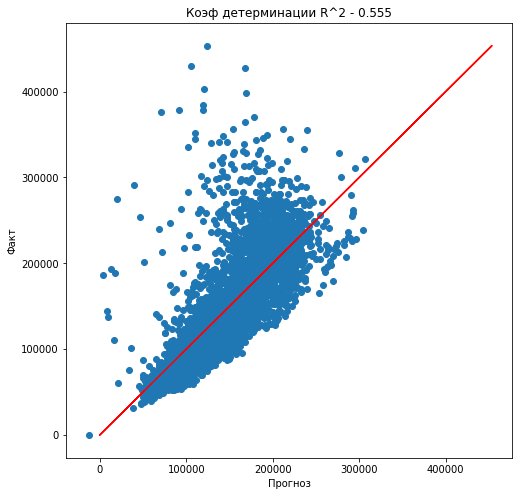

In [155]:
# top_4_docs_90_gropp_D = top_4_docs_90_gropp_H.groupby('datetime')['Количество','Размер_КБ','Время_обработки_сек'].sum().reset_index()
X = top_4_docs_90_gropp_H[['Размер_КБ', 'Количество']]
y = top_4_docs_90_gropp_H['Время_обработки_сек']

# poly = PolynomialFeatures(3)
# X = poly.fit_transform(X)

reg = LinearRegression().fit(X, y)

plt.figure(figsize=(8,8))
plt.plot(x=reg.predict(X), y=y)
plt.plot(y,y, color ='r')
plt.scatter(x=reg.predict(X), y=y)
plt.title('Коэф детерминации R^2 - {}'.format(reg.score(X, y).round(3)))
plt.xlabel('Прогноз')
plt.ylabel('Факт');

## Смотрим качество прогноза. Сравниваем с реальностью

In [157]:
top_4_docs_90_gropp_H['Прогноз'] = reg.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=top_4_docs_90_gropp_H.index, y=top_4_docs_90_gropp_H['Время_обработки_сек'],
                    mode='lines',
                    name='Факт'))
fig.add_trace(go.Scatter(x=top_4_docs_90_gropp_H.index, y=top_4_docs_90_gropp_H['Прогноз'],
                    mode='lines',
                    name='Прогноз'))
fig.show();

# Зависимость времени обработки документов от их количества и объема несомненно существует, но качество прогноза  невысокое. Это может говорить о наличии неучтенных слагаемых скрытых факоров. Неучтенное слагаемое это чеки. Скрытые факторы - это факоры влияющие на время обработки документов, сюда может относиться человеческий фактор, если обработка документа требует участия человека, либо технические факторы связанные с алгоритмом проверки документа. 

# Попробуем избавиться от влияния скрытых факторов, для этого в качестве целевой переменной возьмем не общее время обработки каждого документа а только одного документа ASIIUTIMESIGN (Асииу счетчик 5 мин). Этот доукмент отличается регулярностью размера и временем отправки (каждые 5 минут), также не требует человеческого участия и сложного алгоритма проверки. 

# Также к скрытым факторам могут относиться сбои оборудования

In [158]:
top_4_docs_90_gropp_H.head()

Количество  Размер_КБ  Время_обработки_сек        Прогноз
datetime                                                                      
2019-01-01 00:00:00       39584     443982                51570   61902.662801
2019-01-01 01:00:00       36205     390434                46076   54838.760201
2019-01-01 02:00:00       57312     879439                89143  106139.980726
2019-01-01 03:00:00       31206     391807                55010   48131.310032
2019-01-01 04:00:00       33609     381216                44543   50894.317151

In [159]:
top_4_docs_90.head()

datetime         DocType  Количество  Размер_КБ  \
0 2019-06-16 18:28:00  TRANSFERTOSHOP         214       1436   
2 2019-03-22 02:51:00  TRANSFERTOSHOP          77        575   
3 2019-04-03 13:33:00  TRANSFERTOSHOP         435       2793   
4 2019-04-03 17:28:00  TRANSFERTOSHOP         500       2283   
5 2019-06-25 06:54:00  TRANSFERTOSHOP         332       1386   

   Время_обработки_сек                Документ  
0                  418  Перемещение_в_торг_зал  
2                  100  Перемещение_в_торг_зал  
3                  761  Перемещение_в_торг_зал  
4                 1058  Перемещение_в_торг_зал  
5                  382  Перемещение_в_торг_зал

In [160]:
top_4_docs_90_ASIIU = top_4_docs_90[top_4_docs_90['DocType']=='ASIIUTIMESIGN'].set_index('datetime').resample('H').sum()
top_4_docs_90_ASIIU.rename(columns={'Время_обработки_сек': 'Время_обработки_сек_ASIIU'}, inplace=True)
top_4_docs_90_ASIIU['Скорость_обработки_АССИУ_кб_сек'] =  top_4_docs_90_ASIIU['Размер_КБ'] / top_4_docs_90_ASIIU['Время_обработки_сек_ASIIU']
# top_4_docs_90_ASIIU.drop(columns=['Количество','Размер_КБ'], inplace=True)
top_4_docs_90_ASIIU.head()

Количество  Размер_КБ  Время_обработки_сек_ASIIU  \
datetime                                                                
2019-01-01 00:00:00       19118     205680                      11876   
2019-01-01 01:00:00       16488     177834                       9847   
2019-01-01 02:00:00       15493     167152                       9264   
2019-01-01 03:00:00       16497     178057                       9876   
2019-01-01 04:00:00       17660     191347                      10211   

                     Скорость_обработки_АССИУ_кб_сек  
datetime                                              
2019-01-01 00:00:00                        17.318963  
2019-01-01 01:00:00                        18.059714  
2019-01-01 02:00:00                        18.043178  
2019-01-01 03:00:00                        18.029263  
2019-01-01 04:00:00                        18.739301

In [161]:
total_top = top_4_docs_90_gropp_H.join(top_4_docs_90_ASIIU, how='left', rsuffix='_asiiu').fillna(0)
total_top = total_top[total_top.Время_обработки_сек_ASIIU!=0] # удаляем строки с нулями
total_top.head()

Количество  Размер_КБ  Время_обработки_сек  \
datetime                                                          
2019-01-01 00:00:00       39584     443982                51570   
2019-01-01 01:00:00       36205     390434                46076   
2019-01-01 02:00:00       57312     879439                89143   
2019-01-01 03:00:00       31206     391807                55010   
2019-01-01 04:00:00       33609     381216                44543   

                           Прогноз  Количество_asiiu  Размер_КБ_asiiu  \
datetime                                                                
2019-01-01 00:00:00   61902.662801             19118           205680   
2019-01-01 01:00:00   54838.760201             16488           177834   
2019-01-01 02:00:00  106139.980726             15493           167152   
2019-01-01 03:00:00   48131.310032             16497           178057   
2019-01-01 04:00:00   50894.317151             17660           191347   

                     Время_обработки_сек_ASIIU  \
datetime                                         
2019-01-01 00:00:00                      11876   
2019-01-01 01:00:00                       9847   
2019-01-01 02:00:00                       9264   
2019-01-01 03:00:00                       9876   
2019-01-01 04:00:00                      10211   

                     Скорость_обработки_АССИУ_кб_сек  
datetime                                              
2019-01-01 00:00:00                        17.318963  
2019-01-01 01:00:00                        18.059714  
2019-01-01 02:00:00                        18.043178  
2019-01-01 03:00:00                        18.029263  
2019-01-01 04:00:00                        18.739301

In [162]:
print(stats.pearsonr(total_top.Количество , total_top.Время_обработки_сек_ASIIU)[0])
print(stats.pearsonr(total_top.Размер_КБ , total_top.Время_обработки_сек_ASIIU)[0])
print(stats.pearsonr(total_top.Количество , total_top.Скорость_обработки_АССИУ_кб_сек)[0])
print(stats.pearsonr(total_top.Размер_КБ , total_top.Скорость_обработки_АССИУ_кб_сек)[0])

0.45597186063023126
0.6076627863948518
-0.17179115742027257
-0.5846927318262716


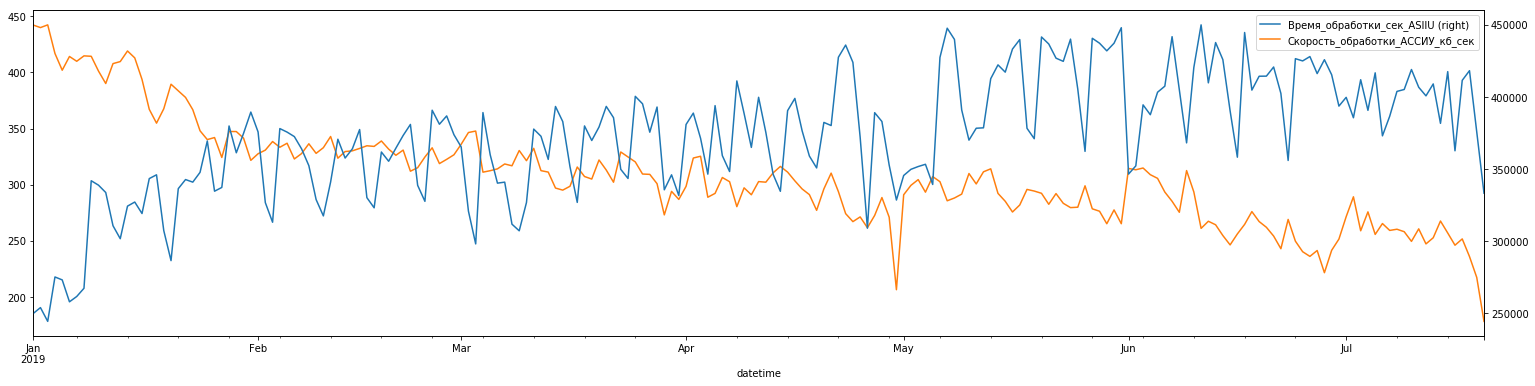

In [163]:
total_top.resample('D').sum()[['Время_обработки_сек_ASIIU', 'Скорость_обработки_АССИУ_кб_сек']].plot(secondary_y='Время_обработки_сек_ASIIU', figsize=(26,6));

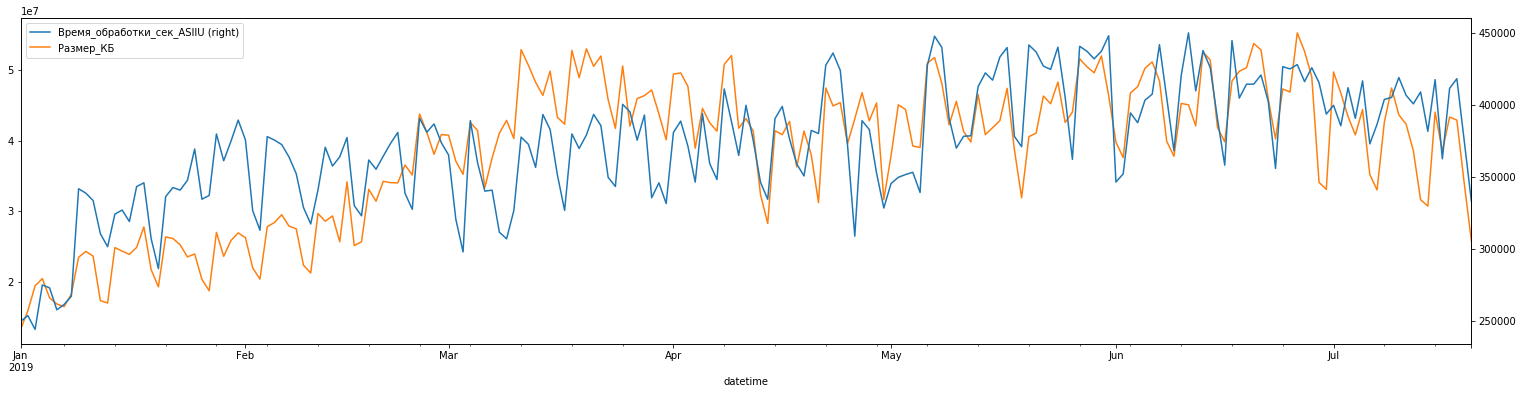

In [164]:
total_top.resample('D').sum()[['Время_обработки_сек_ASIIU', 'Размер_КБ']].plot(secondary_y='Время_обработки_сек_ASIIU', figsize=(26,6));

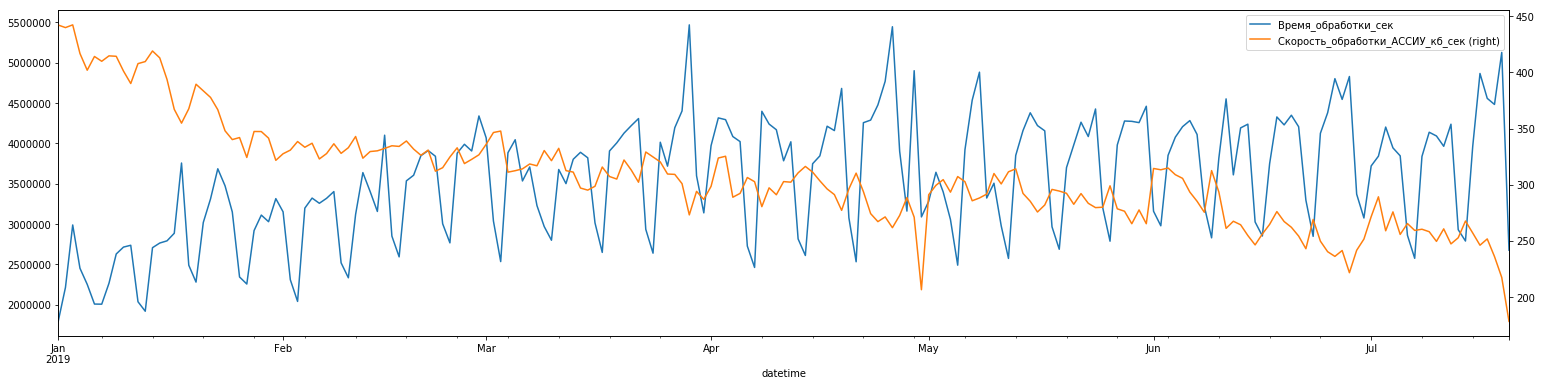

In [165]:
total_top.resample('D').sum()[['Время_обработки_сек', 'Скорость_обработки_АССИУ_кб_сек']].plot(secondary_y='Скорость_обработки_АССИУ_кб_сек', figsize=(26,6));

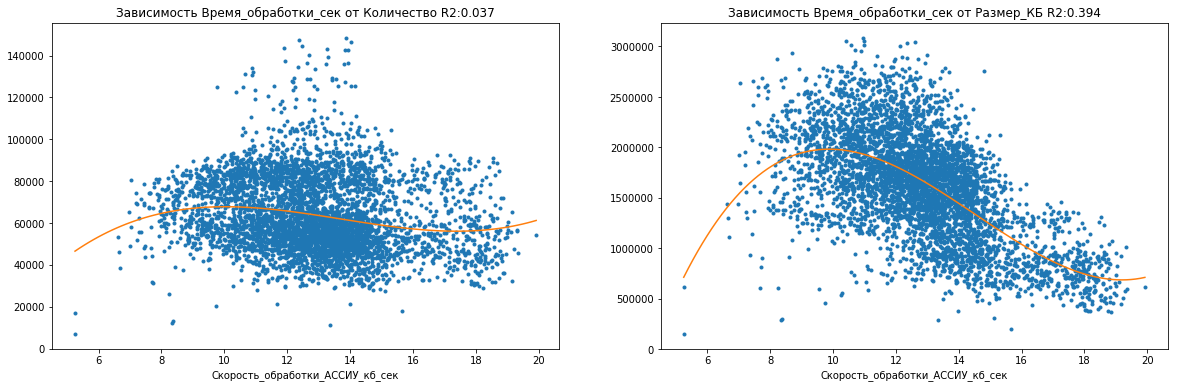

In [166]:
plt.figure(figsize=(20, 6))
for i in enumerate(['Количество','Размер_КБ']):
    
    x = total_top.Скорость_обработки_АССИУ_кб_сек
    y = total_top[i[1]]
    z = np.polyfit(x, y,  3)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)
    
    plt.subplot(1, 2, i[0] + 1)  
    plt.plot(x, y, '.', xp, p(xp), '-')
    plt.title('Зависимость {} от {} R2:{}'.format('Время_обработки_сек', i[1],metrics.r2_score(y, p(x)).round(3) ))
    plt.xlabel('Скорость_обработки_АССИУ_кб_сек')

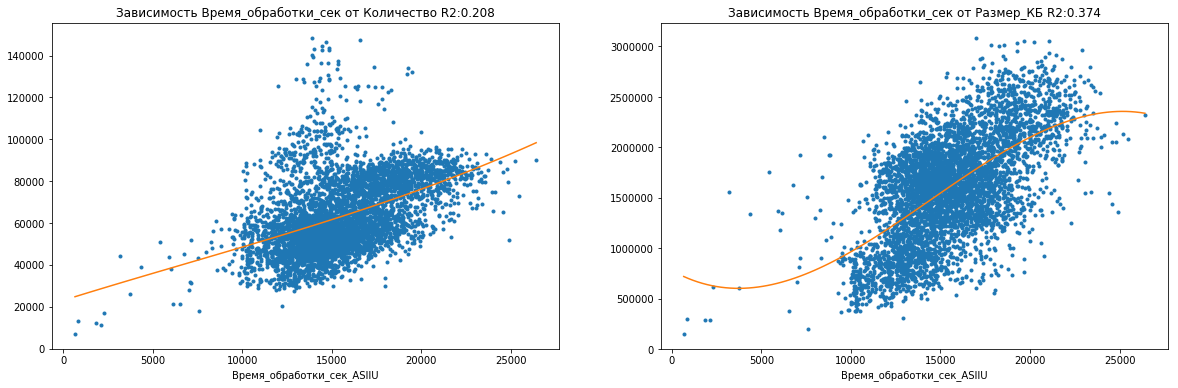

In [167]:
plt.figure(figsize=(20, 6))
for i in enumerate(['Количество','Размер_КБ']):
    
    x = total_top.Время_обработки_сек_ASIIU
    y = total_top[i[1]]
    z = np.polyfit(x, y,  3)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)
    
    plt.subplot(1, 2, i[0] + 1)  
    plt.plot(x, y, '.', xp, p(xp), '-')
    plt.title('Зависимость {} от {} R2:{}'.format('Время_обработки_сек', i[1],metrics.r2_score(y, p(x)).round(3) ))
    plt.xlabel('Время_обработки_сек_ASIIU')

In [168]:
print(np.poly1d(p))

            3          2
-3.552e-07 x + 0.0154 x - 99.91 x + 7.812e+05


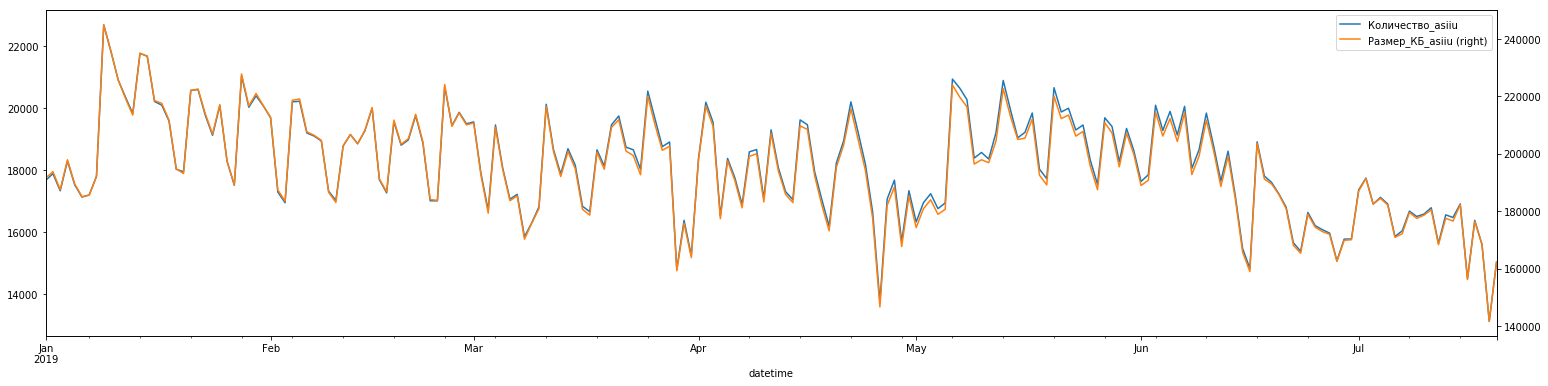

In [169]:
total_top.resample('D').mean()[['Количество_asiiu','Размер_КБ_asiiu']].plot(secondary_y='Размер_КБ_asiiu', figsize=(26,6))

In [170]:
total_top.head()

Количество  Размер_КБ  Время_обработки_сек  \
datetime                                                          
2019-01-01 00:00:00       39584     443982                51570   
2019-01-01 01:00:00       36205     390434                46076   
2019-01-01 02:00:00       57312     879439                89143   
2019-01-01 03:00:00       31206     391807                55010   
2019-01-01 04:00:00       33609     381216                44543   

                           Прогноз  Количество_asiiu  Размер_КБ_asiiu  \
datetime                                                                
2019-01-01 00:00:00   61902.662801             19118           205680   
2019-01-01 01:00:00   54838.760201             16488           177834   
2019-01-01 02:00:00  106139.980726             15493           167152   
2019-01-01 03:00:00   48131.310032             16497           178057   
2019-01-01 04:00:00   50894.317151             17660           191347   

                     Время_обработки_сек_ASIIU  \
datetime                                         
2019-01-01 00:00:00                      11876   
2019-01-01 01:00:00                       9847   
2019-01-01 02:00:00                       9264   
2019-01-01 03:00:00                       9876   
2019-01-01 04:00:00                      10211   

                     Скорость_обработки_АССИУ_кб_сек  
datetime                                              
2019-01-01 00:00:00                        17.318963  
2019-01-01 01:00:00                        18.059714  
2019-01-01 02:00:00                        18.043178  
2019-01-01 03:00:00                        18.029263  
2019-01-01 04:00:00                        18.739301

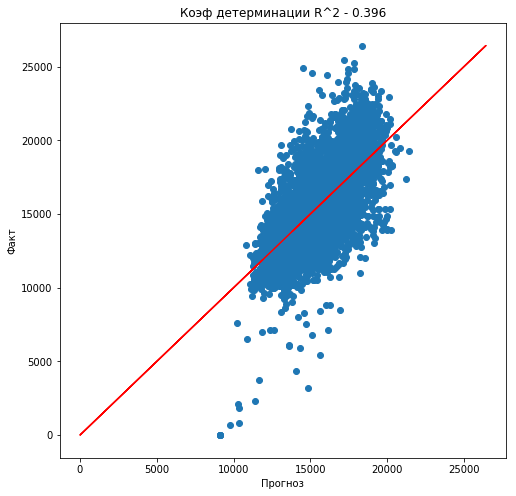

In [171]:
total_top_gropped = total_top.resample('H').sum().reset_index()
X = total_top_gropped[['Размер_КБ', 'Количество']]
y = total_top_gropped['Время_обработки_сек_ASIIU']

# poly = PolynomialFeatures(3)
# X = poly.fit_transform(X)

reg = LinearRegression().fit(X, y)

plt.figure(figsize=(8,8))
plt.plot(x=reg.predict(X), y=y)
plt.plot(y,y, color ='r')
plt.scatter(x=reg.predict(X), y=y)
plt.title('Коэф детерминации R^2 - {}'.format(reg.score(X, y).round(3)))
plt.xlabel('Прогноз')
plt.ylabel('Факт');

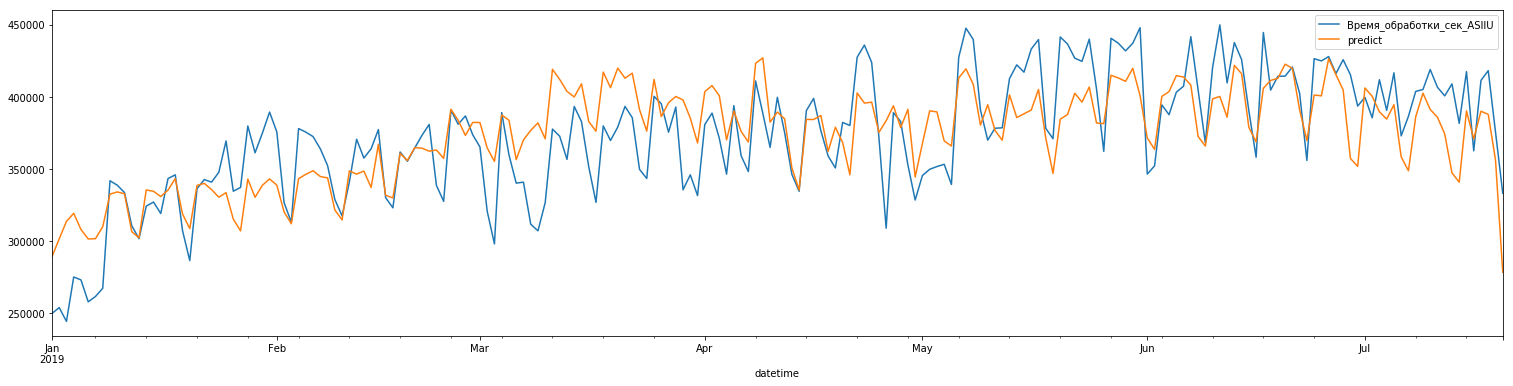

In [172]:
total_top_gropped['predict'] = reg.predict(X)
total_top_gropped.set_index('datetime').resample('D').sum()[['Время_обработки_сек_ASIIU','predict']].plot(figsize=(26,6))